# Import Libraries

In [1]:
import gymnasium as gym
from typing import Tuple
from pathlib import Path
# 
from stable_baselines3 import PPO


In [2]:
import os
import shutil
import pandas as pd
from decimal import Decimal

from nautilus_trader.config import (
    LoggingConfig,
    CacheConfig,
    BacktestDataConfig,
    BacktestEngineConfig,
    BacktestRunConfig,
    BacktestVenueConfig,
    ImportableActorConfig,
    ImportableStrategyConfig,
    RiskEngineConfig,
    StreamingConfig,
)
# from nautilus_trader.backtest.node import BacktestDataConfig
# from nautilus_trader.backtest.node import BacktestEngineConfig
from nautilus_trader.backtest.node import BacktestNode
# from nautilus_trader.backtest.node import BacktestRunConfig
# from nautilus_trader.backtest.node import BacktestVenueConfig
from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.backtest.engine import BacktestEngineConfig
from nautilus_trader.backtest.models import FillModel

from nautilus_trader.model.data import QuoteTick
from nautilus_trader.model.objects import Quantity
from nautilus_trader.model.data import Bar
from nautilus_trader.model.data import BarType
from nautilus_trader.model.identifiers import TraderId

from nautilus_trader.core.datetime import dt_to_unix_nanos
from nautilus_trader.persistence.catalog import ParquetDataCatalog # as DataCatalog

from nautilus_trader.persistence.wranglers import QuoteTickDataWrangler, BarDataWrangler
from nautilus_trader.test_kit.providers import CSVTickDataLoader
from nautilus_trader.test_kit.providers import TestInstrumentProvider


# Historical Data to Catalog

Some historical tick data was gotten from https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed 

In [3]:
# !apt-get update && apt-get install curl -y
# !curl https://raw.githubusercontent.com/nautechsystems/nautilus_data/main/nautilus_data/hist_data_to_catalog.py | python -

In [4]:
# from os import PathLike
# from pathlib import Path

# import requests
# from nautilus_trader.persistence.catalog import ParquetDataCatalog
# from nautilus_trader.persistence.wranglers import QuoteTickDataWrangler
# from nautilus_trader.test_kit.providers import CSVTickDataLoader
# from nautilus_trader.test_kit.providers import TestInstrumentProvider


# ROOT = Path(__file__).parent.parent
# CATALOG_DIR = ROOT / "catalog"
# CATALOG_DIR.mkdir(exist_ok=True)


# def load_fx_hist_data(
#     filename: str,
#     currency: str,
#     catalog_path: PathLike[str] | str,
# ) -> None:
#     instrument = TestInstrumentProvider.default_fx_ccy(currency)
#     wrangler = QuoteTickDataWrangler(instrument)

#     df = CSVTickDataLoader.load(
#         filename,
#         index_col=0,
#         datetime_format="%Y%m%d %H%M%S%f",
#     )
#     df.columns = ["bid_price", "ask_price", "size"]
#     print(df)

#     print("Preparing ticks...")
#     ticks = wrangler.process(df)

#     print("Writing data to catalog...")
#     catalog = ParquetDataCatalog(catalog_path)
#     catalog.write_data([instrument])
#     catalog.write_data(ticks)

#     print("Done")


# def download(url: str) -> None:
#     filename = url.rsplit("/", maxsplit=1)[1]
#     with open(filename, "wb") as f:
#         f.write(requests.get(url).content)


# def main():
#     # Download raw data
#     download(
#         "https://raw.githubusercontent.com/nautechsystems/nautilus_data/main/raw_data/fx_hist_data/DAT_ASCII_EURUSD_T_202001.csv.gz",
#     )
#     load_fx_hist_data(
#         filename="DAT_ASCII_EURUSD_T_202001.csv.gz",
#         currency="EUR/USD",
#         catalog_path=CATALOG_DIR,
#     )


# https://github.com/zcbmlijygrdwa/fx_EUR_USD_tick
# https://github.com/zeta-zetra/forexpy
# https://github.com/drui9/tickterial

# Load Data From Catalog

In [5]:
DATA_DIR = "../data"

path = Path(DATA_DIR).expanduser() / ""
raw_files = list(path.iterdir())
assert raw_files, f"Unable to find any histdata files in directory {path}"
raw_files

[PosixPath('../data/Coinbase_BTCUSD_1h.csv'),
 PosixPath('../data/Coinbase_BTCUSD_d.csv'),
 PosixPath('../data/configuration.json'),
 PosixPath('../data/configuration.yaml'),
 PosixPath('../data/EURUSD_2020-01-01.csv'),
 PosixPath('../data/EURUSD_Ticks_02.09.2024-02.09.2024.csv'),
 PosixPath('../data/EURUSD_Ticks_01.08.2024-01.08.2024.csv')]

In [6]:
raw_files[-1]

# df = pd.DataFrame(data=raw_files[-1].__str__(), columns=[])

PosixPath('../data/EURUSD_Ticks_01.08.2024-01.08.2024.csv')

In [7]:
# Here we just take the first data file found and load into a pandas DataFrame
df = CSVTickDataLoader.load(raw_files[-1], index_col='Local time', datetime_format="%Y-%m-%d %H:%M:%S.%f")
df

,Ask,Bid,AskVolume,BidVolume
Local time,,,,
2024-01-08 00:00:00.114000+01:00,1.08249,1.08246,6.30,3.6
2024-01-08 00:00:00.219000+01:00,1.08248,1.08246,0.90,3.6
2024-01-08 00:00:00.323000+01:00,1.08249,1.08247,0.90,3.6
2024-01-08 00:00:00.427000+01:00,1.08250,1.08246,1.80,5.4
2024-01-08 00:00:00.530000+01:00,1.08250,1.08247,1.80,3.6
...,...,...,...,...
2024-01-08 23:59:52.203000+01:00,1.07890,1.07886,5.49,3.6
2024-01-08 23:59:53.971000+01:00,1.07889,1.07885,5.49,4.5
2024-01-08 23:59:54.075000+01:00,1.07889,1.07884,5.49,5.4


In [8]:
df.iloc[-1]

Ask          1.07888
Bid          1.07884
AskVolume    3.60000
BidVolume    4.50000
Name: 2024-01-08 23:59:55.392000+01:00, dtype: float64

In [9]:
# df.drop(columns=['Unnamed: 0', 'Ask_Volume', 'Bid_Volume'], axis=1, inplace=True)
df.drop(columns=['AskVolume', 'BidVolume'], axis=1, inplace=True)
df

,Ask,Bid
Local time,,
2024-01-08 00:00:00.114000+01:00,1.08249,1.08246
2024-01-08 00:00:00.219000+01:00,1.08248,1.08246
2024-01-08 00:00:00.323000+01:00,1.08249,1.08247
2024-01-08 00:00:00.427000+01:00,1.08250,1.08246
2024-01-08 00:00:00.530000+01:00,1.08250,1.08247
...,...,...
2024-01-08 23:59:52.203000+01:00,1.07890,1.07886
2024-01-08 23:59:53.971000+01:00,1.07889,1.07885
2024-01-08 23:59:54.075000+01:00,1.07889,1.07884


In [10]:
df.index.set_names("timestamp", inplace=True)
# df.columns = ["bid_price", "ask_price"]
df.columns = ["ask_price", "bid_price"]
df

,ask_price,bid_price
timestamp,,
2024-01-08 00:00:00.114000+01:00,1.08249,1.08246
2024-01-08 00:00:00.219000+01:00,1.08248,1.08246
2024-01-08 00:00:00.323000+01:00,1.08249,1.08247
2024-01-08 00:00:00.427000+01:00,1.08250,1.08246
2024-01-08 00:00:00.530000+01:00,1.08250,1.08247
...,...,...
2024-01-08 23:59:52.203000+01:00,1.07890,1.07886
2024-01-08 23:59:53.971000+01:00,1.07889,1.07885
2024-01-08 23:59:54.075000+01:00,1.07889,1.07884


In [11]:
# df = df.reset_index()
# df

In [12]:
# Process quote ticks using a wrangler
EURUSD = TestInstrumentProvider.default_fx_ccy("EUR/USD")
wrangler = QuoteTickDataWrangler(EURUSD)

ticks = wrangler.process(df)
ticks

[QuoteTick(EUR/USD.SIM,1.08246,1.08249,1000000,1000000,1704668400114000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08248,1000000,1000000,1704668400219000000),
 QuoteTick(EUR/USD.SIM,1.08247,1.08249,1000000,1000000,1704668400323000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08250,1000000,1000000,1704668400427000000),
 QuoteTick(EUR/USD.SIM,1.08247,1.08250,1000000,1000000,1704668400530000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08250,1000000,1000000,1704668400633000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08249,1000000,1000000,1704668400838000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08250,1000000,1000000,1704668401041000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08249,1000000,1000000,1704668401349000000),
 QuoteTick(EUR/USD.SIM,1.08245,1.08249,1000000,1000000,1704668401802000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08249,1000000,1000000,1704668401905000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08250,1000000,1000000,1704668402209000000),
 QuoteTick(EUR/USD.SIM,1.08247,1.08250,1000000,1000000,1704668402515000000),

In [13]:
CATALOG_PATH = Path.cwd() / "catalog"

# Clear if it already exists, then create fresh
if CATALOG_PATH.exists():
    shutil.rmtree(CATALOG_PATH)
CATALOG_PATH.mkdir(parents=True)

# Create a catalog instance
catalog = ParquetDataCatalog(CATALOG_PATH)

# Write instrument to the catalog
catalog.write_data([EURUSD])

# Write ticks to catalog
catalog.write_data(ticks)

In [14]:
# You can also use a relative path such as `ParquetDataCatalog("./catalog")`,
# for example if you're running this notebook after the data setup from the docs.

# catalog = DataCatalog("./catalog")
# catalog = DataCatalog.from_env()
# catalog = ParquetDataCatalog("./catalog")
catalog.instruments()


[CurrencyPair(id=EUR/USD.SIM, raw_symbol=EUR/USD, asset_class=FX, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None)]

In [15]:
start = dt_to_unix_nanos(pd.Timestamp("2024-01-08", tz="UTC"))
end =  dt_to_unix_nanos(pd.Timestamp("2024-01-08T23", tz="UTC"))

# start = dt_to_unix_nanos(pd.Timestamp("2024-02-09", tz="UTC"))
# end =  dt_to_unix_nanos(pd.Timestamp("2024-10-09T23", tz="UTC"))

# start = dt_to_unix_nanos(pd.Timestamp("2020-01-03", tz="UTC"))
# end =  dt_to_unix_nanos(pd.Timestamp("2020-01-04", tz="UTC"))

catalog.quote_ticks(instrument_ids=[EURUSD.id.value], start=start, end=end)[:10]

[QuoteTick(EUR/USD.SIM,1.08235,1.08239,1000000,1000000,1704672000487000000),
 QuoteTick(EUR/USD.SIM,1.08235,1.08238,1000000,1000000,1704672000590000000),
 QuoteTick(EUR/USD.SIM,1.08234,1.08237,1000000,1000000,1704672000694000000),
 QuoteTick(EUR/USD.SIM,1.08234,1.08238,1000000,1000000,1704672000798000000),
 QuoteTick(EUR/USD.SIM,1.08234,1.08237,1000000,1000000,1704672000900000000),
 QuoteTick(EUR/USD.SIM,1.08234,1.08236,1000000,1000000,1704672001106000000),
 QuoteTick(EUR/USD.SIM,1.08232,1.08236,1000000,1000000,1704672001618000000),
 QuoteTick(EUR/USD.SIM,1.08232,1.08235,1000000,1000000,1704672001721000000),
 QuoteTick(EUR/USD.SIM,1.08233,1.08234,1000000,1000000,1704672002230000000),
 QuoteTick(EUR/USD.SIM,1.08233,1.08236,1000000,1000000,1704672002333000000)]

In [16]:
catalog.path

'/home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/research/notebooks/catalog'

In [17]:

instrument = catalog.instruments()[0]
instrument

CurrencyPair(id=EUR/USD.SIM, raw_symbol=EUR/USD, asset_class=FX, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None)

# Set up Training Node


## Using High Level Backtest Node

In [18]:
# extend backtest node to TrainingNode
from nautilus_trader.backtest.config import BacktestRunConfig
from nautilus_trader.backtest.node import BacktestVenueConfig
from nautilus_trader.model.enums import AccountType
from nautilus_trader.model.enums import OmsType
from nautilus_trader.model.identifiers import Venue
from nautilus_trader.model.objects import Money


os.environ['NAUTILUS_PATH'] = Path.cwd().__str__()
os.environ['NAUTILUS_PATH']

'/home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/research/notebooks'

### Add Venues

In [19]:
venue_configs = [
    BacktestVenueConfig(
        name="SIM",
        oms_type="HEDGING",
        account_type="MARGIN",  # Spot CASH account (not for perpetuals or futures)
        base_currency="USD",
        starting_balances=["1_000 USD"],
    ),
]

### Add Data

In [20]:
data_configs = [
    BacktestDataConfig(
        catalog_path=str(catalog.path), # str(ParquetDataCatalog.from_env().path)
        data_cls=QuoteTick,
        instrument_id=instrument.id,
        start_time=start,
        end_time=end,
    ),
]

### Add Strategies 

In [21]:
strategies = [
    ImportableStrategyConfig(
        strategy_path="nautilus_trader.examples.strategies.ema_cross:EMACross",
        config_path="nautilus_trader.examples.strategies.ema_cross:EMACrossConfig",
        config={
            "instrument_id": instrument.id,
            "bar_type": "EUR/USD.SIM-15-MINUTE-BID-INTERNAL", # EUR/USD.SIM-15-MINUTE-BID-INTERNAL
            "fast_ema_period": 10,
            "slow_ema_period": 20,
            "trade_size": Decimal(1_000),
        },
    ),
]

### Instantiate Node

In [22]:
# class TrainingNode(BacktestNode):
#     pass

from trade_flow.environments.nautilus_trader import TrainingNode


In [23]:
config = BacktestRunConfig(
    engine=BacktestEngineConfig(strategies=strategies),
    data=data_configs,
    venues=venue_configs,
)

# TODO: check the backtest_high_level.ipynb notebook for reference on how to get this running

node = TrainingNode(configs=[config])

### Run Node

In [24]:
results = node.run()

2024-09-20T13:57:18.299568734Z [INFO] BACKTESTER-001.BacktestEngine: =================================================================
2024-09-20T13:57:18.299586579Z [INFO] BACKTESTER-001.BacktestEngine:  NAUTILUS TRADER - Automated Algorithmic Trading Platform
2024-09-20T13:57:18.299589217Z [INFO] BACKTESTER-001.BacktestEngine:  by Nautech Systems Pty Ltd.
2024-09-20T13:57:18.299591117Z [INFO] BACKTESTER-001.BacktestEngine:  Copyright (C) 2015-2024. All rights reserved.
2024-09-20T13:57:18.299593577Z [INFO] BACKTESTER-001.BacktestEngine: =================================================================
2024-09-20T13:57:18.299595642Z [INFO] BACKTESTER-001.BacktestEngine: 
2024-09-20T13:57:18.299597242Z [INFO] BACKTESTER-001.BacktestEngine: ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣴⣶⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
2024-09-20T13:57:18.299598828Z [INFO] BACKTESTER-001.BacktestEngine: ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⣾⣿⣿⣿⠀⢸⣿⣿⣿⣿⣶⣶⣤⣀⠀⠀⠀⠀⠀
2024-09-20T13:57:18.299600464Z [INFO] BACKTESTER-001.BacktestEngine: ⠀⠀⠀⠀⠀⠀⢀⣴⡇⢀⣾⣿⣿⣿⣿⣿⠀⣾⣿⣿⣿⣿⣿⣿⣿⠿⠓⠀⠀⠀⠀
2024-09-20T13:57

In [25]:
results

[BacktestResult(trader_id='BACKTESTER-001', machine_id='fortesense-hppro3500series', run_config_id='2e478c3050f1753e49eacc9b76513fc518d9c6a16ed1b6a35f23305ca167a5f7', instance_id='cf60c0d4-d464-451e-8295-0f2971b1624b', run_id='fb1bb380-6f2d-4489-a365-f4e2300a30af', run_started=1726840638972342000, run_finished=1726840640925673000, backtest_start=1704672000487000000, backtest_end=1704754795392000000, elapsed_time=82794.905, iterations=0, total_events=20, total_orders=10, total_positions=5, stats_pnls={'USD': {'PnL (total)': -0.55, 'PnL% (total)': -0.05499999999999545, 'Max Winner': 2.29, 'Avg Winner': np.float64(2.29), 'Min Winner': np.float64(2.29), 'Min Loser': np.float64(-0.01), 'Avg Loser': np.float64(-0.71), 'Max Loser': np.float64(-1.81), 'Expectancy': np.float64(-0.10999999999999993), 'Win Rate': 0.2}}, stats_returns={'Returns Volatility (252 days)': np.float64(nan), 'Average (Return)': np.float64(-6.598109824246617e-05), 'Average Loss (Return)': np.float64(-0.0008365339468216485

In [26]:
# results[0].generate_positions_report()

# Using Low Level Backtest Engine (low-level API)

Tutorial for [NautilusTrader](https://nautilustrader.io/docs/) a high-performance algorithmic trading platform and event driven backtester.

[View source on GitHub](https://github.com/nautechsystems/nautilus_trader/blob/develop/docs/getting_started/backtest_low_level.ipynb).

## Overview

This tutorial walks through how to use a `BacktestEngine` to backtest a simple EMA cross strategy
with a TWAP execution algorithm on a simulated Binance Spot exchange using historical trade tick data.

The following points will be covered:
- How to load raw data (external to Nautilus) using data loaders and wranglers
- How to add this data to a `BacktestEngine`
- How to add venues, strategies and execution algorithms to a `BacktestEngine`
- How to run backtests with a  `BacktestEngine`
- Post-run analysis and options for repeated runs

## Prerequisites
- Python 3.10+ installed
- [JupyterLab](https://jupyter.org/) or similar installed (`pip install -U jupyterlab`)
- [NautilusTrader](https://pypi.org/project/nautilus_trader/) latest release installed (`pip install -U nautilus_trader`)

## Imports

We'll start with all of our imports for the remainder of this tutorial.

In [27]:
from decimal import Decimal

from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.backtest.engine import BacktestEngineConfig
from nautilus_trader.examples.algorithms.twap import TWAPExecAlgorithm
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAP
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAPConfig
from nautilus_trader.model.currencies import ETH
from nautilus_trader.model.currencies import USDT
from nautilus_trader.model.data import BarType
from nautilus_trader.model.enums import AccountType
from nautilus_trader.model.enums import OmsType
from nautilus_trader.model.identifiers import TraderId
from nautilus_trader.model.identifiers import Venue
from nautilus_trader.model.objects import Money
from nautilus_trader.persistence.wranglers import TradeTickDataWrangler
from nautilus_trader.test_kit.providers import TestDataProvider
from nautilus_trader.test_kit.providers import TestInstrumentProvider

## Loading data

For this tutorial we'll use some stub test data which exists in the NautilusTrader repository
(this data is also used by the automated test suite to test the correctness of the platform).

Firstly, instantiate a data provider which we can use to read raw CSV trade tick data into memory as a `pd.DataFrame`.
We then need to initialize the instrument which matches the data, in this case the `ETHUSDT` spot cryptocurrency pair for Binance.
We'll use this instrument for the remainder of this backtest run.

Next, we need to wrangle this data into a list of Nautilus `TradeTick` objects, which can we later add to the `BacktestEngine`.

In [28]:
# Load stub test data
provider = TestDataProvider()
trades_df = provider.read_csv_ticks("binance/ethusdt-trades.csv")

# Initialize the instrument which matches the data
ETHUSDT_BINANCE = TestInstrumentProvider.ethusdt_binance()

# Process into Nautilus objects
wrangler = TradeTickDataWrangler(instrument=ETHUSDT_BINANCE)
ticks = wrangler.process(trades_df)
ticks[:10]

Couldn't find test data directory, test data will be pulled from GitHub


[TradeTick(ETHUSDT.BINANCE,423.76,2.67900,SELLER,148568980,1597399200223000000),
 TradeTick(ETHUSDT.BINANCE,423.74,2.31976,SELLER,148568981,1597399200976000000),
 TradeTick(ETHUSDT.BINANCE,423.73,2.16924,SELLER,148568982,1597399200976000000),
 TradeTick(ETHUSDT.BINANCE,423.68,0.19096,SELLER,148568983,1597399201185000000),
 TradeTick(ETHUSDT.BINANCE,423.70,0.82490,BUYER,148568984,1597399201913000000),
 TradeTick(ETHUSDT.BINANCE,423.70,0.10117,BUYER,148568985,1597399202258000000),
 TradeTick(ETHUSDT.BINANCE,423.70,0.63290,BUYER,148568986,1597399202531000000),
 TradeTick(ETHUSDT.BINANCE,423.70,2.50000,BUYER,148568987,1597399203451000000),
 TradeTick(ETHUSDT.BINANCE,423.69,14.75000,SELLER,148568988,1597399204206000000),
 TradeTick(ETHUSDT.BINANCE,423.66,0.16914,BUYER,148568989,1597399204344000000)]

## Initialize a backtest engine

Now we'll need a backtest engine, minimally you could just call `BacktestEngine()` which will instantiate
an engine with a default configuration. 

Here we also show initializing a `BacktestEngineConfig` (will only a custom `trader_id` specified)
to show the general configuration pattern.

See the [Configuration](https://nautilustrader.io/docs/api_reference/config) API reference for details of all configuration options available.

In [29]:
# Configure backtest engine
config = BacktestEngineConfig(trader_id=TraderId("BACKTESTER-001"))

# Build the backtest engine
engine = BacktestEngine(config=config)

2024-09-20T13:57:28.571939690Z [INFO] BACKTESTER-001.BacktestEngine: Building system kernel
2024-09-20T13:57:28.571964270Z [INFO] BACKTESTER-001.MessageBus: config.database=None
2024-09-20T13:57:28.571968707Z [INFO] BACKTESTER-001.MessageBus: config.encoding='msgpack'
2024-09-20T13:57:28.571971638Z [INFO] BACKTESTER-001.MessageBus: config.timestamps_as_iso8601=False
2024-09-20T13:57:28.571974560Z [INFO] BACKTESTER-001.MessageBus: config.buffer_interval_ms=None
2024-09-20T13:57:28.571977357Z [INFO] BACKTESTER-001.MessageBus: config.autotrim_mins=None
2024-09-20T13:57:28.571979930Z [INFO] BACKTESTER-001.MessageBus: config.use_trader_prefix=True
2024-09-20T13:57:28.571982650Z [INFO] BACKTESTER-001.MessageBus: config.use_trader_id=True
2024-09-20T13:57:28.571984869Z [INFO] BACKTESTER-001.MessageBus: config.use_instance_id=False
2024-09-20T13:57:28.571987368Z [INFO] BACKTESTER-001.MessageBus: config.streams_prefix='stream'
2024-09-20T13:57:28.571990544Z [INFO] BACKTESTER-001.MessageBus: con

## Add venues

We'll need a venue to trade on, which should match the *market* data being added to the engine.

In this case we'll set up a *simulated* Binance Spot exchange.

In [30]:
# Add a trading venue (multiple venues possible)
BINANCE = Venue("BINANCE")
engine.add_venue(
    venue=BINANCE,
    oms_type=OmsType.NETTING,
    account_type=AccountType.CASH,  # Spot CASH account (not for perpetuals or futures)
    base_currency=None,  # Multi-currency account
    starting_balances=[Money(1_000_000.0, USDT), Money(10.0, ETH)],
)

2024-09-20T13:57:28.781401272Z [INFO] BACKTESTER-001.SimulatedExchange(BINANCE): OmsType=NETTING
2024-09-20T13:57:28.781476011Z [INFO] BACKTESTER-001.ExecClient-BINANCE: READY
2024-09-20T13:57:28.781605835Z [INFO] BACKTESTER-001.SimulatedExchange(BINANCE): Registered ExecutionClient-BINANCE
2024-09-20T13:57:28.781612133Z [INFO] BACKTESTER-001.ExecEngine: Registered ExecutionClient-BINANCE
2024-09-20T13:57:28.781623405Z [INFO] BACKTESTER-001.BacktestEngine: Added SimulatedExchange(id=BINANCE, oms_type=NETTING, account_type=CASH)


## Add data

Now we can add data to the backtest engine. First add the `Instrument` object we previously initialized, which matches our data.

Then we can add the trade ticks we wrangled earlier.

In [31]:
# Add instrument(s)
engine.add_instrument(ETHUSDT_BINANCE)

# Add data
engine.add_data(ticks)

2024-09-20T13:57:28.972587261Z [INFO] BACKTESTER-001.DataClient-BINANCE: READY
2024-09-20T13:57:28.972605433Z [INFO] BACKTESTER-001.DataEngine: Registered BINANCE
2024-09-20T13:57:28.972806446Z [INFO] BACKTESTER-001.SimulatedExchange(BINANCE): Added instrument ETHUSDT.BINANCE and created matching engine
2024-09-20T13:57:28.972814829Z [INFO] BACKTESTER-001.BacktestEngine: Added ETHUSDT.BINANCE Instrument
2024-09-20T13:57:28.983594682Z [INFO] BACKTESTER-001.BacktestEngine: Added 69,806 ETHUSDT.BINANCE TradeTick elements


:::note
The amount of and variety of data types is only limited by machine resources and your imagination (custom types are possible).
Also, multiple venues can be used for backtesting, again only limited by machine resources.
:::

## Add strategies

Now we can add the trading strategies we’d like to run as part of our system.

:::note
Multiple strategies and instruments can be used for backtesting, only limited by machine resources.
:::

Firstly, initialize a strategy configuration, then use this to initialize a strategy which we can add to the engine:

In [32]:
# Configure your strategy
strategy_config = EMACrossTWAPConfig(
    instrument_id=ETHUSDT_BINANCE.id,
    bar_type=BarType.from_str("ETHUSDT.BINANCE-250-TICK-LAST-INTERNAL"),
    trade_size=Decimal("0.10"),
    fast_ema_period=10,
    slow_ema_period=20,
    twap_horizon_secs=10.0,
    twap_interval_secs=2.5,
)

# Instantiate and add your strategy
strategy = EMACrossTWAP(config=strategy_config)
engine.add_strategy(strategy=strategy)

2024-09-20T13:57:29.197995536Z [INFO] BACKTESTER-001.EMACrossTWAP: READY
2024-09-20T13:57:29.198451343Z [INFO] BACKTESTER-001.ExecEngine: Registered OMS.UNSPECIFIED for Strategy EMACrossTWAP-000
2024-09-20T13:57:29.198457113Z [INFO] BACKTESTER-001.BACKTESTER-001: Registered Strategy EMACrossTWAP-000


You may notice that this strategy config includes parameters related to a TWAP execution algorithm.
This is because we can flexibly use different parameters per order submit, we still need to initialize
and add the actual `ExecAlgorithm` component which will execute the algorithm - which we'll do now.

## Add execution algorithms

NautilusTrader enables us to build up very complex systems of custom components. Here we show just one of the custom components
available, in this case a built-in TWAP execution algorithm. It is configured and added to the engine in generally the same pattern as for strategies:

:::note
Multiple execution algorithms can be used for backtesting, only limited by machine resources.
:::

In [33]:
# Instantiate and add your execution algorithm
exec_algorithm = TWAPExecAlgorithm()  # Using defaults
engine.add_exec_algorithm(exec_algorithm)

2024-09-20T13:57:29.389171631Z [INFO] BACKTESTER-001.TWAPExecAlgorithm: READY
2024-09-20T13:57:29.389324252Z [INFO] BACKTESTER-001.BACKTESTER-001: Registered ExecAlgorithm TWAP


## Run backtest

Now that we have our data, venues and trading system configured - we can run a backtest
Simply call the `.run(...)` method which will run a backtest over all available data by default.

See the [BacktestEngineConfig](https://nautilustrader.io/docs/latest/api_reference/config) API reference for a complete description of all available methods and options.

In [34]:
# Run the engine (from start to end of data)
# engine.run()

## Post-run and analysis

Once the backtest is completed, a post-run tearsheet will be automatically logged using some
default statistics (or custom statistics which can be loaded, see the advanced [Portfolio statistics](../concepts/advanced/portfolio_statistics.md) guide).

Also, many resultant data and execution objects will be held in memory, which we
can use to further analyze the performance by generating various reports.

In [35]:
engine.trader.generate_account_report(BINANCE)

""


In [36]:
engine.trader.generate_order_fills_report()

""


In [37]:
engine.trader.generate_positions_report()

""


## Repeated runs

We can also choose to reset the engine for repeated runs with different strategy and component configurations.
Calling the `.reset(...)` method will retain all loaded data and components, but reset all other stateful values
as if we had a fresh `BacktestEngine` (this avoids having to load the same data again).

In [38]:
# For repeated backtest runs make sure to reset the engine
engine.reset()

2024-09-20T13:57:30.397467854Z [INFO] BACKTESTER-001.DataClient-BINANCE: READY
2024-09-20T13:57:30.397523597Z [INFO] BACKTESTER-001.DataEngine: READY
2024-09-20T13:57:30.397559963Z [INFO] BACKTESTER-001.ExecClient-BINANCE: READY
2024-09-20T13:57:30.397577531Z [INFO] BACKTESTER-001.Cache: Reset
2024-09-20T13:57:30.397602597Z [INFO] BACKTESTER-001.ExecEngine: READY
2024-09-20T13:57:30.397648006Z [INFO] BACKTESTER-001.RiskEngine: READY
2024-09-20T13:57:30.397685262Z [INFO] BACKTESTER-001.OrderEmulator: READY
2024-09-20T13:57:30.397741121Z [INFO] BACKTESTER-001.EMACrossTWAP: READY
2024-09-20T13:57:30.397782367Z [INFO] BACKTESTER-001.TWAPExecAlgorithm: READY
2024-09-20T13:57:30.398097039Z [INFO] BACKTESTER-001.Portfolio: READY
2024-09-20T13:57:30.398106050Z [INFO] BACKTESTER-001.BACKTESTER-001: READY
2024-09-20T13:57:30.398253047Z [INFO] BACKTESTER-001.Portfolio: Updated AccountState(account_id=BINANCE-001, account_type=CASH, base_currency=None, is_reported=True, balances=[AccountBalance(to

Individual components (actors, strategies, execution algorithms) need to be removed and added as required.

See the [Trader](../api_reference/trading.md) API reference for a description of all methods available to achieve this.

In [39]:
# Once done, good practice to dispose of the object if the script continues
engine.dispose()

2024-09-20T13:57:30.624198996Z [INFO] BACKTESTER-001.DataClient-BINANCE: DISPOSED
2024-09-20T13:57:30.624218633Z [INFO] BACKTESTER-001.DataEngine: DISPOSED
2024-09-20T13:57:30.624248136Z [INFO] BACKTESTER-001.RiskEngine: DISPOSED
2024-09-20T13:57:30.624280748Z [INFO] BACKTESTER-001.ExecClient-BINANCE: DISPOSED
2024-09-20T13:57:30.624303335Z [INFO] BACKTESTER-001.ExecEngine: DISPOSED
2024-09-20T13:57:30.624316842Z [INFO] BACKTESTER-001.MessageBus: Closed message bus
2024-09-20T13:57:30.624336971Z [INFO] BACKTESTER-001.BACKTESTER-001: Cleared all actors
2024-09-20T13:57:30.624364858Z [INFO] BACKTESTER-001.EMACrossTWAP: DISPOSED
2024-09-20T13:57:30.624382994Z [INFO] BACKTESTER-001.BACKTESTER-001: Cleared all trading strategies
2024-09-20T13:57:30.624409501Z [INFO] BACKTESTER-001.TWAPExecAlgorithm: DISPOSED
2024-09-20T13:57:30.624423160Z [INFO] BACKTESTER-001.BACKTESTER-001: Cleared all execution algorithms
2024-09-20T13:57:30.624441401Z [INFO] BACKTESTER-001.BACKTESTER-001: DISPOSED


# Create Agent

In [40]:
import datetime
from functools import partial
from typing import List, Optional

from nautilus_trader.common.actor import Actor, ActorConfig

from nautilus_trader.model.data import DataType
from nautilus_trader.model.data import Bar, BarType, BarSpecification
from nautilus_trader.model.enums import AggregationSource
from nautilus_trader.model.identifiers import InstrumentId, PositionId

from nautilus_trader.common.enums import LogColor
from nautilus_trader.core.data import Data
from nautilus_trader.core.datetime import secs_to_nanos, nanos_to_secs, unix_nanos_to_dt

from nautilus_trader.config import StrategyConfig
from nautilus_trader.core.message import Event
from nautilus_trader.model.enums import OrderSide, PositionSide, TimeInForce
from nautilus_trader.model.events.position import (
    PositionChanged,
    PositionClosed,
    PositionEvent,
    PositionOpened,
)

from nautilus_trader.model.objects import Price, Quantity
from nautilus_trader.model.position import Position
from nautilus_trader.trading.strategy import Strategy

from nautilus_trader.model.functions import order_side_to_str



## Supervised Learning 

From Nautilus talks: https://github.com/limx0/nautilus_talks

In [41]:
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [42]:
# CATALOG_PATH = Path.cwd() / "catalog"

# # Clear if it already exists, then create fresh
# if CATALOG_PATH.exists():
#     shutil.rmtree(CATALOG_PATH)
# CATALOG_PATH.mkdir(parents=True)

# # Create a catalog instance
# nautilus_talks_catalog = ParquetDataCatalog(CATALOG_PATH)

# # Write instrument to the catalog
# nautilus_talks_catalog.write_data([EURUSD])

# # Write ticks to catalog
# nautilus_talks_catalog.write_data(ticks)

In [43]:

def fetch_data(instrument_name: str, datetime_format: str = "mixed", interval: str = "1d", start: str = "2020-01-01", end: str = "2021-01-01,", venue: str = "NASDAQ"):
    data: Optional[pd.DataFrame] = yf.download(instrument_name, interval=interval, start=start, end=end)
    data.index = pd.to_datetime(data.index, format=datetime_format)
    data.drop(columns=['Adj Close'], axis=1, inplace=True)
    data.index.set_names("timestamp", inplace=True)
    
    # Process bars using a wrangler
    INSTRUMENT = TestInstrumentProvider.equity(symbol=instrument_name.upper(), venue=venue.upper())
    wrangler = BarDataWrangler(bar_type=BarType.from_str(f"{instrument_name.upper()}.{venue}-1-DAY-LAST-EXTERNAL"), instrument=INSTRUMENT)

    bars = wrangler.process(data)
    
    return INSTRUMENT, bars

# soxx_data = yf.download("SOXX", start="2020-01-01", end="2021-01-01")
# soxx_data

In [44]:
smh_instrument, smh_bars = fetch_data("SMH", interval="1d", datetime_format="%Y-%m-%d %H:%M:%S.%f", start="2020-01-01", end="2021-01-01")
smh_instrument, smh_bars

[*********************100%***********************]  1 of 1 completed


(Equity(id=SMH.NASDAQ, raw_symbol=SMH, asset_class=EQUITY, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=2, price_increment=0.01, size_precision=0, size_increment=1, multiplier=1, lot_size=100, margin_init=0, margin_maint=0, maker_fee=0, taker_fee=0, info=None),
 [Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.89,72.47,71.65,72.34,5200400,1577923200000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.28,71.71,70.94,71.15,9963600,1578009600000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,70.25,70.57,69.89,70.39,6514000,1578268800000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.12,71.82,70.70,71.57,6526000,1578355200000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.57,72.06,71.26,71.69,6112800,1578441600000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.61,72.61,71.42,72.10,6403600,1578528000000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.51,72.51,71.37,71.50,4503800,1578614400000000000),
  Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.10,72.53,71.84,72.50,7211800,

In [45]:
soxx_instrument, soxx_bars = fetch_data("SOXX", interval="1d", datetime_format="%Y-%m-%d %H:%M:%S.%f", start="2020-01-01", end="2021-01-01")
soxx_instrument, soxx_bars

[*********************100%***********************]  1 of 1 completed


(Equity(id=SOXX.NASDAQ, raw_symbol=SOXX, asset_class=EQUITY, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=2, price_increment=0.01, size_precision=0, size_increment=1, multiplier=1, lot_size=100, margin_init=0, margin_maint=0, maker_fee=0, taker_fee=0, info=None),
 [Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.75,85.43,84.33,85.43,1275300,1577923200000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.11,84.57,83.65,83.84,1235100,1578009600000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,82.78,83.23,82.42,82.96,1615200,1578268800000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.00,84.82,83.50,84.49,1146600,1578355200000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.66,84.98,84.05,84.41,1297800,1578441600000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.59,85.59,84.15,84.95,639600,1578528000000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.49,85.49,84.21,84.45,1952100,1578614400000000000),
  Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.04,85.56,84.78,85.44

In [46]:
CATALOG_PATH = Path.cwd() / "catalog"

# Clear if it already exists, then create fresh
if CATALOG_PATH.exists():
    shutil.rmtree(CATALOG_PATH)
CATALOG_PATH.mkdir(parents=True)

# Create a catalog instance
nautilus_talks_catalog = ParquetDataCatalog(CATALOG_PATH)

# Write instrument to the catalog
nautilus_talks_catalog.write_data([smh_instrument, soxx_instrument])

# Write bars to catalog
nautilus_talks_catalog.write_data(smh_bars)
nautilus_talks_catalog.write_data(soxx_bars)

### Pairs Trading Analysis

#### Premise
- Two (or more) assets prices are related in some way
- Their prices typically move together
- Opportunities arise when one assert deviates from the relationship
- Buy one, sell the other with the expectation they will return to their relationship at some point in the future

#### Benefits
- Applicable to a wide range of markets & assets
- market neutral (if the market suddenly tanks, don't lose money)

#### Challenges
- Modelling the relationship (drifting pairs)
- Transaction costs
- Getting "legged"

#### Example
- Two semiconductor ETFs `SMH` (VanEck Semiconductor ETF) and `SOXX` (iShares Semiconductor ETF)
- Fundamental reasons for a relationship (both ETFs of similar stocks)
- Visual analysis of price series confirms belief of relationship

In [47]:
import pathlib
from typing import Tuple

from nautilus_trader.backtest.node import BacktestNode
from nautilus_trader.config import (
    CacheConfig,
    BacktestDataConfig,
    BacktestEngineConfig,
    BacktestRunConfig,
    BacktestVenueConfig,
    ImportableActorConfig,
    ImportableStrategyConfig,
    RiskEngineConfig,
    StreamingConfig,
)
# from nautilus_trader.persistence.catalog import ParquetDataCatalog as DataCatalog




In [48]:
import datetime
import pandas as pd
import hvplot.pandas
import holoviews as hv

# from demo.backtest import CATALOG as catalog
from trade_flow.environments.nautilus_trader.utils import bars_to_dataframe, human_readable_duration, make_bar_type

# conda install hvplot

#### Load Data

In [49]:
# nautilus_talks_catalog_path = str(pathlib.Path.cwd().parent.joinpath("nautilus_talks/20220617/demo/catalog"))
nautilus_talks_catalog_path = str(pathlib.Path.cwd().joinpath("catalog"))
nautilus_talks_catalog_path

'/home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/research/notebooks/catalog'

In [50]:

os.listdir(nautilus_talks_catalog_path)

['data']

In [51]:

# CATALOG = DataCatalog(str(pathlib.Path(__file__).parent.joinpath("catalog")))
nautilus_talks_catalog = ParquetDataCatalog(nautilus_talks_catalog_path)

nautilus_talks_catalog.instruments()

[Equity(id=SMH.NASDAQ, raw_symbol=SMH, asset_class=EQUITY, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=2, price_increment=0.01, size_precision=0, size_increment=1, multiplier=1, lot_size=100, margin_init=0, margin_maint=0, maker_fee=0, taker_fee=0, info=None),
 Equity(id=SOXX.NASDAQ, raw_symbol=SOXX, asset_class=EQUITY, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=2, price_increment=0.01, size_precision=0, size_increment=1, multiplier=1, lot_size=100, margin_init=0, margin_maint=0, maker_fee=0, taker_fee=0, info=None)]

In [52]:
# Load pre-loaded sample data from nautilus DataCatalog
src_id = 'SMH.NASDAQ'
tgt_id = 'SOXX.NASDAQ'

src = nautilus_talks_catalog.bars(instrument_ids=[src_id], start=pd.Timestamp('2020-01-01'), end=pd.Timestamp('2020-01-10'), as_nautilus=True)
tgt = nautilus_talks_catalog.bars(instrument_ids=[tgt_id], start=pd.Timestamp('2020-01-01'), end=pd.Timestamp('2020-01-10'), as_nautilus=True)

In [53]:
src

[Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.89,72.47,71.65,72.34,5200400,1577923200000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.28,71.71,70.94,71.15,9963600,1578009600000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,70.25,70.57,69.89,70.39,6514000,1578268800000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.12,71.82,70.70,71.57,6526000,1578355200000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,71.57,72.06,71.26,71.69,6112800,1578441600000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.61,72.61,71.42,72.10,6403600,1578528000000000000),
 Bar(SMH.NASDAQ-1-DAY-LAST-EXTERNAL,72.51,72.51,71.37,71.50,4503800,1578614400000000000)]

In [54]:
tgt

[Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.75,85.43,84.33,85.43,1275300,1577923200000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.11,84.57,83.65,83.84,1235100,1578009600000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,82.78,83.23,82.42,82.96,1615200,1578268800000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.00,84.82,83.50,84.49,1146600,1578355200000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,84.66,84.98,84.05,84.41,1297800,1578441600000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.59,85.59,84.15,84.95,639600,1578528000000000000),
 Bar(SOXX.NASDAQ-1-DAY-LAST-EXTERNAL,85.49,85.49,84.21,84.45,1952100,1578614400000000000)]

In [55]:
# Merge into single Dataframe for convenience, filter for market hours only
df = bars_to_dataframe(source_id=src_id, source_bars=src, target_id=tgt_id, target_bars=tgt)
df.index = pd.to_datetime(df.index)
# df = df.between_time(datetime.time(14, 30), datetime.time(21,0))

/home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/research/notebooks/util.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = pd.concat([ldf, rdf])["close"].unstack(0).sort_index().fillna(method="ffill")


In [56]:
df

instrument_id,SMH.NASDAQ,SOXX.NASDAQ
ts_init,,
2020-01-02,72.34,85.43
2020-01-03,71.15,83.84
2020-01-06,70.39,82.96
2020-01-07,71.57,84.49
2020-01-08,71.69,84.41
2020-01-09,72.10,84.95
2020-01-10,71.50,84.45


In [57]:
# View scatter plot of SMH vs SOXX
df.pct_change().cumsum().hvplot.step(y=[src_id, tgt_id], title=f"Time Series {src_id} vs {tgt_id}")

:NdOverlay   [instrument_id]
   :Curve   [ts_init]   (value)

In [58]:
# View scatter plot of SMH vs SOXX
df.hvplot.scatter(x=src_id, y=tgt_id, title=f"Price Scatter {src_id} vs {tgt_id}")

:Scatter   [SMH.NASDAQ]   (SOXX.NASDAQ)

#### Fit a (simple) model

In [59]:
# Format values for scikit-learn
X = df.loc[:, src_id].astype(float).values.reshape(-1, 1)
Y = df.loc[:, tgt_id].astype(float).values.reshape(-1, 1)

In [60]:
# Fit a model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression(fit_intercept=False)
model.fit(X, Y)

LinearRegression(fit_intercept=False)

In [61]:
hedge_ratio = float(model.coef_[0][0])

In [62]:
df.loc[:, "predicted"] = (df[src_id] * hedge_ratio)
df.loc[:, "spread"] = df['predicted'] - df[tgt_id]

In [63]:
# df.hvplot.hist("spread", bins=100)

In [64]:
ts_plot = df.hvplot.step(y=[tgt_id, 'predicted']) 
spread_plot = df['spread'].hvplot() * hv.HLine(0).opts(color='r', line_width=1)
(ts_plot + spread_plot).cols(1)

:Layout
   .NdOverlay.I    :NdOverlay   [instrument_id]
      :Curve   [ts_init]   (value)
   .Overlay.Spread :Overlay
      .Curve.Spread :Curve   [ts_init]   (spread)
      .HLine.I      :HLine   [x,y]

#### Example Trade

In [65]:
notional = 10_000
# entry = "2020-01-03 14:43:40" # BUY SMH / SELL SOXX
# exit =  "2020-01-03 14:52:10"

entry = "2020-01-03" # BUY SMH / SELL SOXX
exit =  "2020-01-06"

In [66]:
spread_side = "SELL" if df.loc[entry]['spread'] > 0 else "BUY"
opp_side = {"BUY": "SELL", "SELL": "BUY"}

#### Entry

In [67]:
src_entry_price = df.loc[entry][src_id]
src_shares = int(notional / df.loc[entry][src_id])

tgt_entry_price = df.loc[entry][tgt_id]
tgt_shares = int(notional / df.loc[entry][tgt_id])

print(f"{spread_side} {src_id} @ {src_entry_price}\n{opp_side[spread_side]} {tgt_id} @ {tgt_entry_price}")

SELL SMH.NASDAQ @ 71.15
BUY SOXX.NASDAQ @ 83.84


#### Exit

In [68]:
src_exit_price = df.loc[exit][src_id]
tgt_exit_price = df.loc[exit][tgt_id]

print(f"{opp_side[spread_side]} {src_id} @ {src_exit_price}\n{spread_side} {tgt_id} @ {tgt_exit_price}")

BUY SMH.NASDAQ @ 70.39
SELL SOXX.NASDAQ @ 82.96


#### PnL

In [69]:
CASH_SIDE = {"SELL": 1.0, "BUY": -1.0}
src_pnl = (src_shares * (src_entry_price - src_exit_price)  * CASH_SIDE[spread_side])
tgt_pnl = (tgt_shares * (tgt_entry_price - tgt_exit_price) * CASH_SIDE[opp_side[spread_side]]) 

print(f"{src_id} ({src_shares=}): {spread_side} @ {src_entry_price}, {opp_side[spread_side]} @ {src_exit_price}, {src_pnl=:0.2f}")
print(f"{tgt_id} ({tgt_shares=}): {opp_side[spread_side]} @ {tgt_entry_price}, {spread_side} @ {tgt_exit_price}, {tgt_pnl=:0.2f}")

SMH.NASDAQ (src_shares=140): SELL @ 71.15, BUY @ 70.39, src_pnl=106.40
SOXX.NASDAQ (tgt_shares=119): BUY @ 83.84, SELL @ 82.96, tgt_pnl=-104.72


In [70]:
total_pnl = src_pnl + tgt_pnl
roi = total_pnl / notional

In [71]:
BPS = 10_000
f"{total_pnl = :0.1f}, ROI ($10_000) = {roi * BPS:0.1f} bps"

'total_pnl = 1.7, ROI ($10_000) = 1.7 bps'

In [72]:
trade_time = (pd.Timestamp(exit) - pd.Timestamp(entry))
f"Trade time: {trade_time}"

'Trade time: 3 days 00:00:00'

### Setup Nautilus Trader Node

#### Define Linear Regression Model

In [73]:
class ModelUpdate(Data):
    def __init__(
        self,
        model: LinearRegression,
        hedge_ratio: float,
        std_prediction: float,
        ts_init: int,
    ):
        super().__init__(ts_init=ts_init, ts_event=ts_init)
        self.model = model
        self.hedge_ratio = hedge_ratio
        self.std_prediction = std_prediction

class Prediction(Data):
    def __init__(
        self,
        instrument_id: str,
        prediction: float,
        ts_init: int,
    ):
        super().__init__(ts_init=ts_init, ts_event=ts_init)
        self.instrument_id = instrument_id
        self.prediction = prediction

class PredictedPriceConfig(ActorConfig):
    source_symbol: str
    target_symbol: str
    bar_spec: str = "10-SECOND-LAST"
    min_model_timedelta: str = "1D"



In [74]:

class PredictedPriceActor(Actor):
    def __init__(self, config: PredictedPriceConfig):
        super().__init__(config=config)

        self.source_id = InstrumentId.from_str(config.source_symbol)
        self.target_id = InstrumentId.from_str(config.target_symbol)
        self.bar_spec = BarSpecification.from_str(self.config.bar_spec)
        self.model: Optional[LinearRegression] = None
        self.hedge_ratio: Optional[float] = None
        self._min_model_timedelta = secs_to_nanos(pd.Timedelta(self.config.min_model_timedelta).total_seconds())
        self._last_model = pd.Timestamp(0)

    def on_start(self):
        # Set instruments
        self.left = self.cache.instrument(self.source_id)
        self.right = self.cache.instrument(self.target_id)

        # Subscribe to bars
        self.subscribe_bars(make_bar_type(instrument_id=self.source_id, bar_spec=self.bar_spec))
        self.subscribe_bars(make_bar_type(instrument_id=self.target_id, bar_spec=self.bar_spec))

    def on_bar(self, bar: Bar):
        self._check_model_fit(bar)
        self._predict(bar)

    @property
    def data_length_valid(self) -> bool:
        return self._check_first_tick(self.source_id) and self._check_first_tick(self.target_id)

    @property
    def has_fit_model_today(self):
        return unix_nanos_to_dt(self.clock.timestamp_ns()).date() == self._last_model.date()

    def _check_first_tick(self, instrument_id) -> bool:
        """Check we have enough bar data for this `instrument_id`, according to `min_model_timedelta`"""
        bars = self.cache.bars(bar_type=make_bar_type(instrument_id, bar_spec=self.bar_spec))
        if not bars:
            return False
        delta = self.clock.timestamp_ns() - bars[-1].ts_init
        return delta > self._min_model_timedelta

    def _check_model_fit(self, bar: Bar):
        # Check we have the minimum required data
        if not self.data_length_valid:
            return

        # Check we haven't fit a model yet today
        if self.has_fit_model_today:
            return

        # Generate a dataframe from cached bar data
        df = bars_to_dataframe(
            source_id=self.source_id.value,
            source_bars=self.cache.bars(bar_type=make_bar_type(self.source_id, bar_spec=self.bar_spec)),
            target_id=self.target_id.value,
            target_bars=self.cache.bars(bar_type=make_bar_type(self.target_id, bar_spec=self.bar_spec)),
        )

        # Format the arrays for scikit-learn
        X = df.loc[:, self.source_id.value].astype(float).values.reshape(-1, 1)
        Y = df.loc[:, self.target_id.value].astype(float).values.reshape(-1, 1)

        # Fit a model
        self.model = LinearRegression(fit_intercept=False)
        self.model.fit(X, Y)
        self.log.info(
            f"Fit model @ {unix_nanos_to_dt(bar.ts_init)}, r2: {r2_score(Y, self.model.predict(X))}",
            color=LogColor.BLUE,
        )
        self._last_model = unix_nanos_to_dt(bar.ts_init)

        # Record std dev of predictions (used for scaling our order price)
        pred = self.model.predict(X)
        errors = pred - Y
        std_pred = errors.std()

        # The model slope is our hedge ratio (the ratio of source
        self.hedge_ratio = float(self.model.coef_[0][0])
        self.log.info(f"Computed hedge_ratio={self.hedge_ratio:0.4f}", color=LogColor.BLUE)

        # Publish model
        model_update = ModelUpdate(
            model=self.model, hedge_ratio=self.hedge_ratio, std_prediction=std_pred, ts_init=bar.ts_init
        )
        self.publish_data(
            data_type=DataType(ModelUpdate, metadata={"instrument_id": self.target_id.value}), data=model_update
        )

    def _predict(self, bar: Bar):
        if self.model is not None and bar.bar_type.instrument_id == self.source_id:
            pred = self.model.predict([[bar.close]])[0][0]
            prediction = Prediction(instrument_id=self.target_id, prediction=pred, ts_init=bar.ts_init)
            self.publish_data(
                data_type=DataType(Prediction, metadata={"instrument_id": self.target_id.value}), data=prediction
            )


#### Define Strategy

In [75]:
class PairTraderConfig(StrategyConfig):
    source_symbol: str
    target_symbol: str
    notional_trade_size_usd: int = 10_000
    min_model_timedelta: datetime.timedelta = datetime.timedelta(days=1)
    trade_width_std_dev: float = 2.5
    bar_spec: str = "10-SECOND-LAST"
    ib_long_short_margin_requirement = (0.25 + 0.17) / 2.0

class RepeatedEventComplete(Exception):
    pass


In [76]:
class PairTrader(Strategy):
    def __init__(self, config: PairTraderConfig):
        super().__init__(config=config)
        self.source_id = InstrumentId.from_str(config.source_symbol)
        self.target_id = InstrumentId.from_str(config.target_symbol)
        self.model: Optional[ModelUpdate] = None
        self.hedge_ratio: Optional[float] = None
        self.std_pred: Optional[float] = None
        self.prediction: Optional[float] = None
        self._current_edge: float = 0.0
        self._current_required_edge: float = 0.0
        self.bar_spec = BarSpecification.from_str(self.config.bar_spec)
        self._summarised: set = set()
        self._position_id: int = 0

    def on_start(self):
        # Set instruments
        self.source = self.cache.instrument(self.source_id)
        self.target = self.cache.instrument(self.target_id)

        # Subscribe to bars
        self.subscribe_bars(make_bar_type(instrument_id=self.source_id, bar_spec=self.bar_spec))
        self.subscribe_bars(make_bar_type(instrument_id=self.target_id, bar_spec=self.bar_spec))

        # Subscribe to model and predictions
        self.subscribe_data(data_type=DataType(ModelUpdate, metadata={"instrument_id": self.target_id.value}))
        self.subscribe_data(data_type=DataType(Prediction, metadata={"instrument_id": self.target_id.value}))

    def on_bar(self, bar: Bar):
        self._update_theoretical()
        self._check_for_entry(bar)
        self._check_for_exit(timer=None, bar=bar)

    def on_data(self, data: Data):
        if isinstance(data, ModelUpdate):
            self._on_model_update(data)
        elif isinstance(data, Prediction):
            self._on_prediction(data)
        else:
            raise TypeError()

    def on_event(self, event: Event):
        self._check_for_hedge(timer=None, event=event)
        if isinstance(event, (PositionOpened, PositionChanged)):
            position = self.cache.position(event.position_id)
            self._log.info(f"{position}", color=LogColor.YELLOW)
            assert position.quantity < 200  # Runtime check for bug in code

    def _on_model_update(self, model_update: ModelUpdate):
        self.model = model_update.model
        self.hedge_ratio = model_update.hedge_ratio
        self.std_pred = model_update.std_prediction

    def _on_prediction(self, prediction: Prediction):
        self.prediction = prediction.prediction
        self._update_theoretical()

    def _update_theoretical(self):
        """We've either received an update Bar market or a new prediction, update our `current_edge`"""
        if not self.prediction:
            return

        quote_right: Bar = self.cache.bar(make_bar_type(self.target_id, bar_spec=self.bar_spec))
        if not quote_right:
            return

        self._current_edge = 0
        close_target = quote_right.close
        if (self.prediction - close_target) > 0:
            self._current_edge = self.prediction - close_target
        elif (close_target - self.prediction) > 0:
            self._current_edge = close_target - self.prediction

    def _check_for_entry(self, bar: Bar):
        if bar.bar_type.instrument_id == self.target_id and self.prediction is not None:
            # Send in orders
            quote_target: Bar = self.cache.bar(make_bar_type(self.target_id, bar_spec=self.bar_spec))
            if not quote_target:
                return

            market_right = quote_target.close
            self._current_required_edge = self.std_pred * self.config.trade_width_std_dev

            if self._current_edge > self._current_required_edge:
                # Our theoretical price is above the market; we want to buy
                side = OrderSide.BUY
                max_volume = int(self.config.notional_trade_size_usd / market_right)
                capped_volume = self._cap_volume(instrument_id=self.target_id, max_quantity=max_volume)
                price = self.prediction - self._current_required_edge
                self._log.debug(f"{side} {max_volume=} {capped_volume=} {price=}")
            elif self._current_edge < -self._current_required_edge:
                # Our theoretical price is below the market; we want to sell
                side = OrderSide.SELL
                max_volume = int(self.config.notional_trade_size_usd / market_right)
                capped_volume = self._cap_volume(instrument_id=self.target_id, max_quantity=max_volume)
                price = self.prediction + self._current_required_edge
                self._log.debug(f"{side} {max_volume=} {capped_volume=} {price=}")
            else:
                return
            if capped_volume == 0:
                # We're at our max limit, cancel any remaining orders and return
                for order in self.cache.orders_open(instrument_id=self.target_id, strategy_id=self.id):
                    self.cancel_order(order=order)
                return
            self._log.info(
                f"Entry opportunity: {side} market={market_right}, "
                f"theo={self.prediction:0.3f} {capped_volume=} ({self._current_edge=:0.3f}, "
                f"{self._current_required_edge=:0.3f})",
                color=LogColor.GREEN,
            )
            # Cancel any existing orders
            for order in self.cache.orders_open(instrument_id=self.target_id, strategy_id=self.id):
                self.cancel_order(order=order)
            order = self.order_factory.limit(
                instrument_id=self.target_id,
                order_side=side,
                price=Price(price, self.target.price_precision),
                quantity=Quantity.from_int(capped_volume),
                time_in_force=TimeInForce.IOC,
            )
            self._log.info(f"ENTRY {order.info()}", color=LogColor.BLUE)
            self.submit_order(order, PositionId(f"target-{self._position_id}"))

    def _cap_volume(self, instrument_id: InstrumentId, max_quantity: int) -> int:
        position_quantity = 0
        position = self.current_position(instrument_id)
        if position is not None:
            position_quantity = position.quantity
        return max(0, max_quantity - position_quantity)

    def _check_for_hedge(self, timer=None, event: Optional[Event] = None):
        if not ((isinstance(event, (PositionEvent,)) and event.instrument_id == self.target_id)):
            return

        timer_name = f"hedge-{self.id}"
        try:
            self._hedge_position(event)
            # Keep scheduling this method to run until we're hedged
            if timer_name in self.clock.timer_names:
                self.clock.cancel_timer(timer_name)
            self.clock.set_time_alert(
                name=timer_name,
                alert_time=self.clock.utc_now() + pd.Timedelta(seconds=2),
                callback=partial(self._check_for_hedge, event=event),
            )
        except RepeatedEventComplete:
            # Hedge is complete, return
            if timer_name in self.clock.timer_names:
                self.clock.cancel_timer(timer_name)
            return

    def _hedge_position(self, event: PositionEvent):
        # We've opened or changed position in our source instrument, we will likely need to hedge.
        target_position = self.cache.position(event.position_id)
        hedge_quantity = int(round(target_position.quantity * self.hedge_ratio, 0))
        quantity = 0
        if isinstance(event, PositionClosed):
            # (possibly) Reducing our position in the target instrument
            source_position: Position = self.current_position(self.source_id)
            if source_position is not None and source_position.is_closed:
                if source_position.id.value not in self._summarised:
                    self._summarise_position()
                    self._position_id += 1
                quantity = source_position.quantity
                side = self._opposite_side(source_position.side)
        else:
            # (possibly) Increasing our position in hedge instrument
            side = self._opposite_side(target_position.side)
            quantity = self._cap_volume(instrument_id=self.source_id, max_quantity=hedge_quantity)

        if quantity == 0:
            # Fully hedged, cancel any existing orders
            for order in self.cache.orders_open(instrument_id=self.source_id, strategy_id=self.id):
                self.cancel_order(order=order)
            raise RepeatedEventComplete
        elif self.cache.orders_inflight(instrument_id=self.source_id, strategy_id=self.id):
            # Don't send more orders if we have some currently in-flight
            return

        # Cancel any existing orders
        for order in self.cache.orders_open(instrument_id=self.source_id, strategy_id=self.id):
            self.cancel_order(order=order)
        order = self.order_factory.market(
            instrument_id=self.source_id,
            order_side=side,
            quantity=Quantity.from_int(quantity),
        )
        self._log.info(f"ENTRY HEDGE {order.info()}", color=LogColor.BLUE)
        self.submit_order(order, PositionId(f"source-{self._position_id}"))
        return order

    def _check_for_exit(self, timer=None, bar: Optional[Bar] = None):
        if not self.cache.positions(strategy_id=self.id):
            return

        # Keep checking that we have successfully got a hedge
        timer_name = f"exit-{self.id}"
        try:
            self._exit_position(bar=bar)
            # Keep scheduling this method to run until we're exited
            if timer_name in self.clock.timer_names:
                self.clock.cancel_timer(timer_name)
            self.clock.set_time_alert(
                name=timer_name,
                alert_time=self.clock.utc_now() + pd.Timedelta(seconds=2),
                callback=partial(self._check_for_exit, bar=bar),
            )
        except RepeatedEventComplete:
            # Hedge is complete, return
            if timer_name in self.clock.timer_names:
                self.clock.cancel_timer(timer_name)
            return

    def _exit_position(self, bar: Bar):
        position: Position = self.current_position(self.target_id)
        if position is not None:
            if position.is_closed:
                raise RepeatedEventComplete()
            if self._current_edge < (self._current_required_edge * 0.25):
                if self.cache.orders_inflight(instrument_id=self.target_id, strategy_id=self.id):
                    # Order currently in-flight, don't send again
                    return
                self._log.info(
                    f"Trigger to close position {self._current_edge=:0.3f} {self._current_required_edge=:0.3f} (* 0.25)",
                    color=LogColor.CYAN,
                )
                # We're close back to fair value, we should try and close our position
                order = self.order_factory.market(
                    instrument_id=self.target_id,
                    order_side=self._opposite_side(position.side),
                    quantity=position.quantity,
                )
                self._log.info(f"CLOSE {order.info()}", color=LogColor.BLUE)
                self.submit_order(order, PositionId(f"target-{self._position_id}"))

    def current_position(self, instrument_id: InstrumentId) -> Optional[Position]:
        try:
            side = {self.source_id: "source", self.target_id: "target"}[instrument_id]
            return self.cache.position(PositionId(f"{side}-{self._position_id}"))
        except AssertionError:
            return None

    def _opposite_side(self, side: PositionSide):
        return {PositionSide.LONG: OrderSide.SELL, PositionSide.SHORT: OrderSide.BUY, PositionSide.FLAT: None}[side]

    def _summarise_position(self):
        src_pos: Position = self.current_position(instrument_id=self.source_id)
        tgt_pos: Position = self.current_position(instrument_id=self.target_id)
        self.log.warning("Hedge summary:", color=LogColor.BLUE)
        self.log.warning(
            f"target: {order_side_to_str(tgt_pos.events[0].order_side)} {tgt_pos.peak_qty}, "
            f"{tgt_pos.avg_px_open=}, {tgt_pos.avg_px_close=}, {tgt_pos.realized_return=:0.4f}",
            color=LogColor.NORMAL,
        )
        self.log.warning(
            f"source: {order_side_to_str(src_pos.events[0].order_side)} {src_pos.peak_qty}, "
            f"{src_pos.avg_px_open=}, {src_pos.avg_px_close=}, {src_pos.realized_return=:0.4f}",
            color=LogColor.NORMAL,
        )

        def peak_notional(pos):
            entry_order = self.cache.order(pos.events[0].client_order_id)
            return pos.peak_qty * {OrderSide.BUY: 1.0, OrderSide.SELL: -1.0}[entry_order.side] * pos.avg_px_open

        tgt_notional = peak_notional(tgt_pos)
        src_notional = peak_notional(src_pos)
        margin_requirements = (abs(tgt_notional) + abs(src_notional)) * self.config.ib_long_short_margin_requirement
        pnl = src_pos.realized_pnl + tgt_pos.realized_pnl
        return_bps = float(pnl) / margin_requirements * 10_000
        self.log.warning(
            f"position duration = {human_readable_duration(src_pos.duration_ns)} "
            f"(opened={unix_nanos_to_dt(src_pos.ts_opened)}, closed={unix_nanos_to_dt(src_pos.ts_closed)}",
            color=LogColor.NORMAL,
        )
        self.log.warning(
            f"Spread=({tgt_notional:.0f}/{src_notional:.0f}), total_margin_required={margin_requirements:0.1f} "
            f"PNL=${pnl}, margin_return={return_bps:0.1f}bps\n",
            color=LogColor.GREEN if pnl > 0 else LogColor.RED,
        )

        self._summarised.add(src_pos.id.value)

    def on_stop(self):
        self.close_all_positions(self.source_id)
        self.close_all_positions(self.target_id)





#### Run Model Backtest

In [77]:

def main(
    instrument_ids: Tuple[str, str],
    catalog: ParquetDataCatalog,
    notional_trade_size_usd: int = 10_000,
    start_time: str = None,
    end_time: str = None,
    log_level: str = "ERROR",
    bypass_logging: bool = False,
    persistence: bool = False,
    **strategy_kwargs,
):
    # Create model prediction actor
    prediction = ImportableActorConfig(
        actor_path="model:PredictedPriceActor",
        config_path="model:PredictedPriceConfig",
        config=dict(
            source_symbol=instrument_ids[0],
            target_symbol=instrument_ids[1],
        ),
    )

    # Create strategy
    strategy = ImportableStrategyConfig(
        strategy_path="strategy:PairTrader",
        config_path="strategy:PairTraderConfig",
        config=dict(
            source_symbol=instrument_ids[0],
            target_symbol=instrument_ids[1],
            notional_trade_size_usd=notional_trade_size_usd,
            **strategy_kwargs,
        ),
    )

    # Create backtest engine
    engine = BacktestEngineConfig(
        trader_id="BACKTESTER-001",
        cache=CacheConfig(tick_capacity=100_000),
        # bypass_logging=bypass_logging,
        # log_level=log_level,
        streaming=StreamingConfig(catalog_path=str(catalog.path)) if persistence else None,
        risk_engine=RiskEngineConfig(max_order_submit_rate="1000/00:00:01"),  # type: ignore
        strategies=[strategy],
        actors=[prediction],
    )
    venues = [
        BacktestVenueConfig(
            name="NASDAQ", 
            oms_type="NETTING",
            account_type="CASH",
            base_currency="USD",
            starting_balances=["1_000_000 USD"],
        )
    ]
    print("instrument_ids => ", instrument_ids)
    data = [
        BacktestDataConfig(
            data_cls=Bar.fully_qualified_name(),
            catalog_path=str(catalog.path),
            catalog_fs_protocol=catalog.fs_protocol,
            catalog_fs_storage_options=catalog.fs_storage_options,
            instrument_id=InstrumentId.from_str(instrument_id),
            start_time=start_time,
            end_time=end_time,
        )
        for instrument_id in instrument_ids
    ]

    run_config = BacktestRunConfig(engine=engine, venues=venues, data=data)
    
    print("venues => ", run_config.venues)
    node = BacktestNode(configs=[run_config])
    return node.run()


In [78]:
# # typer.run(main)
# # lr_catalog = LR_MODEL_DATA_CATALOG

# assert len(nautilus_talks_catalog.instruments())>0, "Couldn't load instruments, have you run `poetry run inv extract-catalog`?"
    
# [result] = main(
#         catalog=nautilus_talks_catalog,
#         instrument_ids=("SMH.NASDAQ", "SOXX.NASDAQ"),
#         # instrument_ids=("EURUSD.SIM"),
#         log_level="INFO",
#         persistence=False,
#         end_time="2020-06-01",
#     )

# print(result.instance_id)


## Reinforcement Learning  


In [79]:
import gymnasium as gym
from trade_flow.environments import gym_anytrading

from stable_baselines3 import PPO

# Things to understand here:
# Writing a Renderer

import matplotlib.pyplot as plt

from trade_flow.environments.generic import Renderer

import numpy as np
import pandas as pd

# from gymnasium import register

# import trade_flow.environments.default as default

# from trade_flow.environments.default.rewards import PBR, RiskAdjustedReturns
# from trade_flow.environments.default.rewards import SimpleProfit
# from trade_flow.environments.default.actions import BSH, ManagedRiskOrders
# from trade_flow.feed.core import DataFeed, Stream
# from trade_flow.feed.core.base import NameSpace
# from trade_flow.environments.default.oms.exchanges import Exchange, ExchangeOptions
# from trade_flow.environments.default.oms.instruments import USD, BTC
# from trade_flow.environments.default.oms.services.execution.simulated import execute_order
# from trade_flow.environments.default.oms import Wallet, Portfolio

In [80]:
env = gym.make('forex-v0') # render_mode="human"
# env = gym.make('stocks-v0')

/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (24, 2)
  logger.warn(


In [81]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())


env information:
> shape: (24, 2)
> df.shape: (6225, 5)
> prices.shape: (6225,)
> signal_features.shape: (6225, 2)
> max_possible_profit: 4.0541177


In [82]:
# env.reset()
# env.render()

In [83]:
# iterations = 200

# # env = gym.make("CartPole-v1", render_mode="human")

# model = PPO("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=10_000)

# vec_env = model.get_env()
# obs = vec_env.reset()
# for i in range(iterations):
#     action, _states = model.predict(obs, deterministic=False)
#     obs, reward, done, info = vec_env.step(action)
#     vec_env.render()
#     # VecEnv resets automatically
#     # if done:
#     #   obs = env.reset()

# env.close()

# # plt.cla()
# # env.unwrapped.render_all()
# # plt.show()

/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(


info: {'total_reward': np.float32(27.89616), 'total_profit': np.float32(0.9898121), 'position': <Positions.Long: 1>}


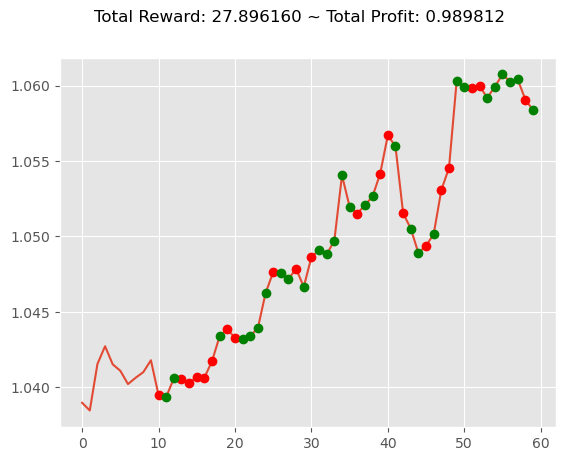

In [84]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from trade_flow.environments import gym_anytrading
from trade_flow.environments.gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from trade_flow.environments.gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL


env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

observation = env.reset(seed=2023)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

### SB3 Algorithms Vs Random Actions 

In [85]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
# import gym_anytrading
from trade_flow.environments import gym_anytrading

from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback

import torch

#### Create Env

In [86]:
env_name = 'forex-v0'  # or 'forex-v0' | 'stocks-v0'
env = gym.make(env_name)

/home/fortesenselabs/anaconda3/envs/algo_trading/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (24, 2)
  logger.warn(


#### Define Functions

In [87]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

#### Train + Test Env

In [88]:
# seed = 42  # random seed
# total_num_episodes = 100 # 50

# print ("env_name                 :", env_name)
# print ("seed                     :", seed)

# # INIT matplotlib
# plot_settings = {}
# plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# # Random actions
# model = None 
# total_learning_timesteps = 0
# rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
# min, avg, max = print_stats(rewards)
# class_name = f'Random actions'
# label = f'Avg. {avg:>7.2f} : {class_name}'
# plot_data['rnd_rewards'] = rewards
# plot_settings['rnd_rewards'] = {'label': label}

# learning_timesteps_list_in_K = [25]
# # learning_timesteps_list_in_K = [50, 250, 500]
# # learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# # RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
# model_class_list = [A2C, PPO, DQN]

# for timesteps in learning_timesteps_list_in_K:
#     total_learning_timesteps = timesteps * 1000
#     step_key = f'{timesteps}K'

#     for model_class in model_class_list:
#         policy_dict = model_class.policy_aliases
#         # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
#         # MlpPolicy or MlpLstmPolicy
#         policy = policy_dict.get('MlpPolicy')
#         if policy is None:
#             policy = policy_dict.get('MlpLstmPolicy')
#         # print ('policy:', policy, 'model_class:', model_class)

#         try:
#             model = model_class(policy, env, verbose=0)
#             class_name = type(model).__qualname__
#             plot_key = f'{class_name}_rewards_'+step_key
#             rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
#             min, avg, max, = print_stats(rewards)
#             label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
#             plot_data[plot_key] = rewards
#             plot_settings[plot_key] = {'label': label}     
                   
#         except Exception as e:
#             print(f"ERROR: {str(e)}")
#             continue

#### Plot Results

In [89]:
# data = pd.DataFrame(plot_data)

# sns.set_style('whitegrid')
# plt.figure(figsize=(8, 6))

# for key in plot_data:
#     if key == 'x':
#         continue
#     label = plot_settings[key]['label']
#     line = plt.plot('x', key, data=data, linewidth=1, label=label)

# plt.xlabel('episode')
# plt.ylabel('reward')
# plt.title('Random vs. SB3 Agents')
# plt.legend()
# plt.show()

### Nautilus Trader Plugins

In [90]:
from time import time
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

from decimal import Decimal

from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.backtest.engine import BacktestEngineConfig
from nautilus_trader.examples.algorithms.twap import TWAPExecAlgorithm
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAP
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAPConfig
from nautilus_trader.model.currencies import ETH
from nautilus_trader.model.currencies import USDT
from nautilus_trader.model.data import BarType
from nautilus_trader.model.enums import AccountType
from nautilus_trader.model.enums import OmsType
from nautilus_trader.model.identifiers import TraderId
from nautilus_trader.model.identifiers import Venue
from nautilus_trader.persistence.wranglers import TradeTickDataWrangler
from nautilus_trader.test_kit.providers import TestDataProvider
from nautilus_trader.test_kit.providers import TestInstrumentProvider



In [91]:
DATA_DIR = "../data"

path = Path(DATA_DIR).expanduser() / ""
raw_files = list(path.iterdir())
assert raw_files, f"Unable to find any histdata files in directory {path}"
raw_files

[PosixPath('../data/Coinbase_BTCUSD_1h.csv'),
 PosixPath('../data/Coinbase_BTCUSD_d.csv'),
 PosixPath('../data/configuration.json'),
 PosixPath('../data/configuration.yaml'),
 PosixPath('../data/EURUSD_2020-01-01.csv'),
 PosixPath('../data/EURUSD_Ticks_02.09.2024-02.09.2024.csv'),
 PosixPath('../data/EURUSD_Ticks_01.08.2024-01.08.2024.csv')]

In [92]:
# Here we just take the first data file found and load into a pandas DataFrame
df = CSVTickDataLoader.load(raw_files[-1], index_col='Local time', datetime_format="%Y-%m-%d %H:%M:%S.%f")
df

,Ask,Bid,AskVolume,BidVolume
Local time,,,,
2024-01-08 00:00:00.114000+01:00,1.08249,1.08246,6.30,3.6
2024-01-08 00:00:00.219000+01:00,1.08248,1.08246,0.90,3.6
2024-01-08 00:00:00.323000+01:00,1.08249,1.08247,0.90,3.6
2024-01-08 00:00:00.427000+01:00,1.08250,1.08246,1.80,5.4
2024-01-08 00:00:00.530000+01:00,1.08250,1.08247,1.80,3.6
...,...,...,...,...
2024-01-08 23:59:52.203000+01:00,1.07890,1.07886,5.49,3.6
2024-01-08 23:59:53.971000+01:00,1.07889,1.07885,5.49,4.5
2024-01-08 23:59:54.075000+01:00,1.07889,1.07884,5.49,5.4


In [93]:
# df.drop(columns=['Unnamed: 0', 'Ask_Volume', 'Bid_Volume'], axis=1, inplace=True)
df.drop(columns=['AskVolume', 'BidVolume'], axis=1, inplace=True)
df.index.set_names("timestamp", inplace=True)
# df.columns = ["bid_price", "ask_price"]
df.columns = ["ask_price", "bid_price"]
df

,ask_price,bid_price
timestamp,,
2024-01-08 00:00:00.114000+01:00,1.08249,1.08246
2024-01-08 00:00:00.219000+01:00,1.08248,1.08246
2024-01-08 00:00:00.323000+01:00,1.08249,1.08247
2024-01-08 00:00:00.427000+01:00,1.08250,1.08246
2024-01-08 00:00:00.530000+01:00,1.08250,1.08247
...,...,...
2024-01-08 23:59:52.203000+01:00,1.07890,1.07886
2024-01-08 23:59:53.971000+01:00,1.07889,1.07885
2024-01-08 23:59:54.075000+01:00,1.07889,1.07884


In [94]:
# Process quote ticks using a wrangler
EURUSD = TestInstrumentProvider.default_fx_ccy("EUR/USD")
wrangler = QuoteTickDataWrangler(EURUSD)

ticks = wrangler.process(df)
ticks[:10]

[QuoteTick(EUR/USD.SIM,1.08246,1.08249,1000000,1000000,1704668400114000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08248,1000000,1000000,1704668400219000000),
 QuoteTick(EUR/USD.SIM,1.08247,1.08249,1000000,1000000,1704668400323000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08250,1000000,1000000,1704668400427000000),
 QuoteTick(EUR/USD.SIM,1.08247,1.08250,1000000,1000000,1704668400530000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08250,1000000,1000000,1704668400633000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08249,1000000,1000000,1704668400838000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08250,1000000,1000000,1704668401041000000),
 QuoteTick(EUR/USD.SIM,1.08246,1.08249,1000000,1000000,1704668401349000000),
 QuoteTick(EUR/USD.SIM,1.08245,1.08249,1000000,1000000,1704668401802000000)]

In [95]:
CATALOG_PATH = Path.cwd() / "catalog"

# Clear if it already exists, then create fresh
if CATALOG_PATH.exists():
    shutil.rmtree(CATALOG_PATH)
CATALOG_PATH.mkdir(parents=True)

# Create a catalog instance
catalog = ParquetDataCatalog(CATALOG_PATH)

# Write instrument to the catalog
catalog.write_data([EURUSD])

# Write ticks to catalog
catalog.write_data(ticks)

In [96]:
start = dt_to_unix_nanos(pd.Timestamp("2024-01-08", tz="UTC"))
end =  dt_to_unix_nanos(pd.Timestamp("2024-01-08T23", tz="UTC"))

catalog.quote_ticks(instrument_ids=[EURUSD.id.value], start=start, end=end)[:10]

[QuoteTick(EUR/USD.SIM,1.08235,1.08239,1000000,1000000,1704672000487000000),
 QuoteTick(EUR/USD.SIM,1.08235,1.08238,1000000,1000000,1704672000590000000),
 QuoteTick(EUR/USD.SIM,1.08234,1.08237,1000000,1000000,1704672000694000000),
 QuoteTick(EUR/USD.SIM,1.08234,1.08238,1000000,1000000,1704672000798000000),
 QuoteTick(EUR/USD.SIM,1.08234,1.08237,1000000,1000000,1704672000900000000),
 QuoteTick(EUR/USD.SIM,1.08234,1.08236,1000000,1000000,1704672001106000000),
 QuoteTick(EUR/USD.SIM,1.08232,1.08236,1000000,1000000,1704672001618000000),
 QuoteTick(EUR/USD.SIM,1.08232,1.08235,1000000,1000000,1704672001721000000),
 QuoteTick(EUR/USD.SIM,1.08233,1.08234,1000000,1000000,1704672002230000000),
 QuoteTick(EUR/USD.SIM,1.08233,1.08236,1000000,1000000,1704672002333000000)]

In [97]:
catalog.instruments()

[CurrencyPair(id=EUR/USD.SIM, raw_symbol=EUR/USD, asset_class=FX, instrument_class=SPOT, quote_currency=USD, is_inverse=False, price_precision=5, price_increment=0.00001, size_precision=0, size_increment=1, multiplier=1, lot_size=1000, margin_init=0.03, margin_maint=0.03, maker_fee=0.00002, taker_fee=0.00002, info=None)]

#### Environment First Approach 

##### Base Class

In [98]:
from enum import Enum
import gymnasium as gym
import pandas as pd

from nautilus_trader.backtest.config import BacktestDataConfig, BacktestRunConfig, BacktestVenueConfig
from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.backtest.engine import BacktestEngineConfig
from nautilus_trader.backtest.results import BacktestResult

from nautilus_trader.core import nautilus_pyo3
from nautilus_trader.core.nautilus_pyo3 import DataBackendSession
from nautilus_trader.core.inspect import is_nautilus_class
from nautilus_trader.core.correctness import PyCondition

from nautilus_trader.common.config import ActorFactory, InvalidConfiguration
from nautilus_trader.common.component import Logger, LogGuard

from nautilus_trader.model import BOOK_DATA_TYPES
from nautilus_trader.model.data import Bar
from nautilus_trader.model.data import capsule_to_list
from nautilus_trader.model.enums import AccountType
from nautilus_trader.model.enums import BookType
from nautilus_trader.model.enums import OmsType
from nautilus_trader.model.enums import book_type_from_str
from nautilus_trader.model.objects import Currency, Money
from nautilus_trader.model.identifiers import ClientId, InstrumentId, Venue


In [99]:
class Actions(Enum):
    Sell = 0
    Buy = 1

class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


In [100]:
class BaseNTTradingEnv(gym.Env):
    """
    Base OpenAI Gym API shell for nautilus trader algorithmic trading platform.
    """
    
    # `episode` - plotted episode results.
    # `human` - raw_state observation in conventional human-readable format.
    #  <obs_space_key> - rendering of arbitrary state presented in observation_space with same key.
    metadata = {'render_modes': ['human', 'episode'], 'render_fps': 3}

    random_seed = None

    closed = True

    def __init__(self, df, window_size, render_mode = None, nt_config: BacktestRunConfig = None):
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']

        PyCondition.not_none(nt_config, "nt_config")
        PyCondition.not_empty(nt_config, "nt_config")
        PyCondition.true(isinstance(nt_config, BacktestRunConfig), "nt_config")

        self._validate_config(nt_config)

        # gym environment
        self.render_mode = render_mode
        self.df = df
        self.window_size = window_size
        # self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, 5) # (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # Nautilus Trader engine
        self._nt_config: BacktestRunConfig = nt_config
        self._log_guard: nautilus_pyo3.LogGuard | LogGuard | None = None
        # self._engine: BacktestEngine | None = None

        self._engine: BacktestEngine = self._create_engine(
            # run_config_id=nt_config.id,
            config=nt_config.engine,
            venue_configs=nt_config.venues,
            data_configs=nt_config.data,
        )

        self.batch_size_bytes: int = 5000
        
        # Create session for entire stream
        self.session = DataBackendSession(chunk_size=self.batch_size_bytes)
        self._run_streaming(data_configs=nt_config.data)

        
        self.reward = 0
        self._seed(2024)
        
    @property
    def config(self) -> BacktestRunConfig:
        """
        Return the loaded backtest run config for the training environment node.

        Returns
        -------
        BacktestRunConfig

        """
        return self._nt_config
    
    @property
    def get_log_guard(self) -> nautilus_pyo3.LogGuard | LogGuard | None:
        """
        Return the global logging systems log guard.

        May return ``None`` if no internal engines are initialized yet.

        Returns
        -------
        nautilus_pyo3.LogGuard | LogGuard | None

        """
        return self._log_guard

    @property
    def get_engine(self) -> BacktestEngine | None:
        """
        Return the backtest engine.

        Returns
        -------
        BacktestEngine or ``None``

        """
        return self._engine
    
    @classmethod
    def _load_catalog(cls, config: BacktestDataConfig) -> ParquetDataCatalog:
        return ParquetDataCatalog(
            path=config.catalog_path,
            fs_protocol=config.catalog_fs_protocol,
            fs_storage_options=config.catalog_fs_storage_options,
        )
    
    def _seed(self, seed=None):
        """
        Sets env. random seed.

        Args:
            seed:   int or None
        """
        self.random_seed = seed
        np.random.seed(self.random_seed)

    
    def _validate_config(self, config: BacktestRunConfig) -> None:  
        venue_ids: list[Venue] = [Venue(c.name) for c in config.venues]

        for data_config in config.data:
            if data_config.instrument_id is None:
                continue  # No instrument associated with data

            if data_config.start_time is not None and data_config.end_time is not None:
                start = dt_to_unix_nanos(data_config.start_time)
                end = dt_to_unix_nanos(data_config.end_time)

                if end < start:
                    raise InvalidConfiguration(
                            f"`end_time` ({data_config.end_time}) is before `start_time` ({data_config.start_time})",
                        )

            instrument_id: InstrumentId = data_config.instrument_id
            if instrument_id.venue not in venue_ids:
                raise InvalidConfiguration(
                        f"Venue '{instrument_id.venue}' for {instrument_id} "
                        f"does not have a `BacktestVenueConfig`",
                    )

        for venue_config in config.venues:
            venue = Venue(venue_config.name)
            book_type = book_type_from_str(venue_config.book_type)

            # Check order book data configuration
            if book_type in (BookType.L2_MBP, BookType.L3_MBO):
                has_book_data = any(
                    data_config.instrument_id
                    and data_config.instrument_id.venue == venue
                    and data_config.data_type in BOOK_DATA_TYPES
                    for data_config in config.data
                )

                if not has_book_data:
                    raise InvalidConfiguration(
                        f"No order book data available for {venue} with book type {venue_config.book_type}",
                    )

    def _create_engine(
        self,
        config: BacktestEngineConfig,
        venue_configs: list[BacktestVenueConfig],
        data_configs: list[BacktestDataConfig],
    ) -> BacktestEngine:
        # Build the backtest engine
        self._engine = BacktestEngine(config=config)

        # Assign the global logging system guard to keep it alive for
        # the duration of the nodes runs.
        log_guard = self._engine.kernel.get_log_guard()
        if log_guard:
            self._log_guard = log_guard

        # Add venues (must be added prior to instruments)
        for config in venue_configs:
            base_currency: str | None = config.base_currency
            leverages = (
                {InstrumentId.from_str(i): Decimal(v) for i, v in config.leverages.items()}
                if config.leverages
                else {}
            )

            self._engine.add_venue(
                venue=Venue(config.name),
                oms_type=OmsType[config.oms_type],
                account_type=AccountType[config.account_type],
                base_currency=Currency.from_str(base_currency) if base_currency else None,
                starting_balances=[Money.from_str(m) for m in config.starting_balances],
                default_leverage=Decimal(config.default_leverage),
                leverages=leverages,
                book_type=book_type_from_str(config.book_type),
                routing=config.routing,
                modules=[ActorFactory.create(module) for module in (config.modules or [])],
                frozen_account=config.frozen_account,
                reject_stop_orders=config.reject_stop_orders,
                support_gtd_orders=config.support_gtd_orders,
                support_contingent_orders=config.support_contingent_orders,
                use_position_ids=config.use_position_ids,
                use_random_ids=config.use_random_ids,
                use_reduce_only=config.use_reduce_only,
            )

        # Add instruments
        for config in data_configs:
            if is_nautilus_class(config.data_type):
                catalog = self._load_catalog(config)
                instruments = catalog.instruments(instrument_ids=config.instrument_id)
                for instrument in instruments or []:
                    if instrument.id not in engine.cache.instrument_ids():
                        self._engine.add_instrument(instrument)

        return self._engine
    
    def _run_streaming(
        self,
        data_configs: list[BacktestDataConfig]
    ) -> None:

        # Add query for all data configs
        for config in data_configs:
            catalog = self._load_catalog(config)
            if config.data_type == Bar:
                # TODO: Temporary hack - improve bars config and decide implementation with `filter_expr`
                assert config.instrument_id, "No `instrument_id` for Bar data config"
                assert config.bar_spec, "No `bar_spec` for Bar data config"
                bar_type = config.instrument_id + "-" + config.bar_spec + "-EXTERNAL"
            else:
                bar_type = None
            session = catalog.backend_session(
                data_cls=config.data_type,
                instrument_ids=(
                    [config.instrument_id] if config.instrument_id and not bar_type else []
                ),
                bar_types=[bar_type] if bar_type else [],
                start=config.start_time,
                end=config.end_time,
                session=self.session,
            )
    
    def step(self, action):
        self._truncated = False

        # Stream data
        for chunk in self.session.to_query_result():
            self._engine.add_data(
                data=capsule_to_list(chunk),
                validate=False,  # Cannot validate mixed type stream
                sort=True,  # Temporarily sorting  # Already sorted from kmerge
            )
            self._engine.run(
                run_config_id=self._nt_config.id,
                streaming=True,
            )
            self._engine.clear_data()

        self._engine.end()

        # if dispose_on_completion:
        #     # Drop data and all state
        #     engine.dispose()
        # else:
        #     # Drop data
        #     engine.clear_data()

        # return engine.get_result()
        # Drop data
        # engine.clear_data()

        # result = self._engine.get_result()
        # print(self._engine.get_result())
        print(self._engine.trader.generate_positions_report())

        # self._engine.trader.generate_account_report(BINANCE)
        # self._engine.trader.generate_order_fills_report()
        # self._engine.trader.generate_positions_report()

        # Drop data and all state
        # engine.dispose()

        self.reward += 1 

        return observation, reward, False, self._truncated, info
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options) 

        if self._engine is not None:
            self._engine.reset()

    def close(self):
        # plt.close()
        
        if self._engine is not None:
            if not self._engine.trader.is_disposed:
                self._engine.dispose()
    



##### Create environments form the base class (I am not sure there will be need for this, if the base class is gotten correctly)

In [101]:
# class ForexV1Env(BaseNTTradingEnv):

#     def __init__(self, df, window_size, frame_bound, unit_side='left', render_mode=None):
#         assert len(frame_bound) == 2
#         assert unit_side.lower() in ['left', 'right']

#         self.frame_bound = frame_bound
#         self.unit_side = unit_side.lower()
#         super().__init__(df, window_size, render_mode)

#         self.trade_fee = 0.0003  # unit

In [102]:
from gymnasium.envs.registration import register
from copy import deepcopy

from trade_flow.environments.gym_anytrading import datasets

register(
    id="nautilus-trader-v0",
    entry_point=BaseNTTradingEnv, #"trade_flow.environments.gym_anytrading.envs:ForexEnv",
    kwargs={
        "df": deepcopy(datasets.FOREX_EURUSD_1H_ASK),
        "window_size": 24,
        # "frame_bound": (24, len(datasets.FOREX_EURUSD_1H_ASK)),
    },
)

##### Test

In [103]:
# Add Venues 
venue_configs = [
    BacktestVenueConfig(
        name="SIM",
        oms_type="HEDGING",
        account_type="MARGIN",  # Spot CASH account (not for perpetuals or futures)
        base_currency="USD",
        starting_balances=["1_000 USD"],
    ),
]

# Add Data
data_configs = [
    BacktestDataConfig(
        catalog_path=str(catalog.path), # str(ParquetDataCatalog.from_env().path)
        data_cls=QuoteTick,
        instrument_id=instrument.id,
        start_time=start,
        end_time=end,
    ),
]

# Add strategies 
strategies = [
    ImportableStrategyConfig(
        strategy_path="nautilus_trader.examples.strategies.ema_cross:EMACross",
        config_path="nautilus_trader.examples.strategies.ema_cross:EMACrossConfig",
        config={
            "instrument_id": instrument.id,
            "bar_type": "EUR/USD.SIM-15-MINUTE-BID-INTERNAL", # EUR/USD.SIM-15-MINUTE-BID-INTERNAL
            "fast_ema_period": 10,
            "slow_ema_period": 20,
            "trade_size": Decimal(1_000),
        },
    ),
]

# Compile config
nt_config = BacktestRunConfig(
    engine=BacktestEngineConfig(strategies=strategies),
    data=data_configs,
    venues=venue_configs,
)

In [104]:
# env = gym.make("nautilus-trader-v0", nt_config=nt_config)

In [105]:
# done = False 
# observation = env.reset()
# while not done: 
#     action = env.action_space.sample() # random action
#     obs, reward, done, _, info = env.step(action) 
#     print('ACTION: {}\nREWARD: {}\nINFO: {}'.format(action, reward, info))
    
# env.close()

#### Agent First Approach

##### Define Base Class

In [106]:
# Agents can extend actors 

class AgentConfig(ActorConfig):
    source_symbol: str
    target_symbol: str
    bar_spec: str = "10-SECOND-LAST"
    min_model_timedelta: str = "1D"

class Agent(Actor):
    def __init__(self, config: AgentConfig):
        super().__init__(config=config)


In [107]:
# # typer.run(main)
# # lr_catalog = LR_MODEL_DATA_CATALOG

# assert len(nautilus_talks_catalog.instruments())>0, "Couldn't load instruments, have you run `poetry run inv extract-catalog`?"
    
# [result] = main(
#         catalog=nautilus_talks_catalog,
#         instrument_ids=("SMH.NASDAQ", "SOXX.NASDAQ"),
#         # instrument_ids=("EURUSD.SIM"),
#         log_level="INFO",
#         persistence=False,
#         end_time="2020-06-01",
#     )

# print(result.instance_id)


# DUMP

In [108]:
# import uuid
# import logging

# from typing import Dict, Any, Optional, Tuple
# from random import randint

# # import gymnasium
# import numpy as np

# # from nautilus_trader.model.enums import AssetClass
# # from trade_flow.core import TimeIndexed, Clock, TraderId, Component
# # from trade_flow.environments.generic import (
# #     ActionScheme,
# #     RewardScheme,
# #     Observer,
# #     Stopper,
# #     Informer,
# #     Renderer,
# # )


# class TradingEnvironment(gymnasium.Env):
#     """A trading environment made for use with Gym-compatible reinforcement
#     learning algorithms.
#     """ 
#     pass

In [109]:
stop

NameError: name 'stop' is not defined

## Add simulation module

We can optionally plug in a module to simulate rollover interest. The data is available from pre-packaged test data.

In [ ]:
from nautilus_trader.backtest.modules import FXRolloverInterestConfig
from nautilus_trader.backtest.modules import FXRolloverInterestModule
from nautilus_trader.test_kit.providers import TestDataProvider

provider = TestDataProvider()
interest_rate_data = provider.read_csv("../data/short-term-interest.csv")
config = FXRolloverInterestConfig(interest_rate_data)
fx_rollover_interest = FXRolloverInterestModule(config=config)

## Add fill model

For this backtest we'll use a simple probabilistic fill model.

In [ ]:
fill_model = FillModel(
    prob_fill_on_limit=0.2,
    prob_fill_on_stop=0.95,
    prob_slippage=0.5,
    random_seed=42,
)

## Add venue

For this backtest we just need a single trading venue which will be a similated FX ECN.

In [ ]:
from nautilus_trader.model.currencies import JPY
from nautilus_trader.model.currencies import USD
from nautilus_trader.model.enums import AccountType
from nautilus_trader.model.enums import OmsType
from nautilus_trader.model.identifiers import Venue
from nautilus_trader.model.objects import Money

SIM = Venue("SIM")
engine.add_venue(
    venue=SIM,
    oms_type=OmsType.HEDGING,  # Venue will generate position IDs
    account_type=AccountType.MARGIN,
    base_currency=None,  # Multi-currency account
    starting_balances=[Money(1_000_000, USD), Money(10_000_000, JPY)],
    fill_model=fill_model,
    modules=[fx_rollover_interest],
)

Now we can add instruments and data. For this backtest we'll pre-process bid and ask side bar data into quote ticks using a `QuoteTickDataWrangler`.

## Configure strategy

Next we'll configure and initialize a simple `EMACross` strategy we'll use for the backtest.

In [ ]:
from nautilus_trader.examples.strategies.ema_cross import EMACross
from nautilus_trader.examples.strategies.ema_cross import EMACrossConfig

# Configure your strategy
config = EMACrossConfig(
    instrument_id=USDJPY_SIM.id,
    bar_type=BarType.from_str("USD/JPY.SIM-5-MINUTE-BID-INTERNAL"),
    fast_ema_period=10,
    slow_ema_period=20,
    trade_size=Decimal(1_000_000),
)

# Instantiate and add your strategy
strategy = EMACross(config=config)
# engine.add_strategy(strategy=strategy)

In [ ]:
# from nautilus_trader.examples.strategies.subscribe import SubscribeStrategy
# from nautilus_trader.examples.strategies.subscribe import SubscribeStrategyConfig

# # Instantiate your strategy
# class PSubscribeStrategy(SubscribeStrategy):
#     def __init__(self, config: SubscribeStrategyConfig) -> None:
#         super().__init__(config)

#     def on_start(self) -> None:
#         """
#         Actions to be performed on strategy start.
#         """
#         self.instrument = self.cache.instrument(self.instrument_id)
#         if self.instrument is None:
#             self.log.error(f"Could not find instrument for {self.instrument_id}")
#             self.stop()
#             return

#         if self.config.book_type:
#             self.book = OrderBook(
#                 instrument_id=self.instrument.id,
#                 book_type=self.config.book_type,
#             )
#             if self.config.snapshots:
#                 self.subscribe_order_book_at_interval(
#                     instrument_id=self.instrument_id,
#                     book_type=self.config.book_type,
#                 )
#             else:
#                 self.subscribe_order_book_deltas(
#                     instrument_id=self.instrument_id,
#                     book_type=self.config.book_type,
#                 )

#         if self.config.trade_ticks:
#             self.subscribe_trade_ticks(instrument_id=self.instrument_id)
#         if self.config.quote_ticks:
#             self.subscribe_quote_ticks(instrument_id=self.instrument_id)
#         if self.config.bars:
#             bar_type: BarType = BarType(
#                 instrument_id=self.instrument_id,
#                 bar_spec=BarSpecification(
#                     step=1,
#                     aggregation=BarAggregation.MINUTE,
#                     price_type=PriceType.LAST,
#                 ),
#                 aggregation_source=AggregationSource.EXTERNAL,
#             )
#             self.subscribe_bars(bar_type)

#     def on_bar(self, bar: Bar) -> None:
#         print("bar => ", bar)


# # Configure your strategy
# # strategy_config = SubscribeStrategyConfig(
# #     instrument_id=InstrumentId.from_str(f"Step Index.{BROKER_SERVER}"),  # "EUR/USD.{BROKER_SERVER}"
# #     quote_ticks=True,
# #     bars=True,
# # )

# strategy = PSubscribeStrategy(config=strategy_config)

In [ ]:
from nautilus_trader.common.enums import LogColor
from nautilus_trader.config import StrategyConfig
from nautilus_trader.core.correctness import PyCondition
from nautilus_trader.indicators.ta_lib.manager import TAFunctionWrapper
from nautilus_trader.indicators.ta_lib.manager import TALibIndicatorManager
from nautilus_trader.model.data import Bar
from nautilus_trader.model.data import BarType
from nautilus_trader.model.instruments import Instrument
from nautilus_trader.trading.strategy import Strategy


class TALibStrategyConfig(StrategyConfig, frozen=True):
    """
    Configuration for ``TALibStrategy`` instances.

    Parameters
    ----------
    bar_type : BarType
        The bar type for the strategy.

    """

    bar_type: BarType



class TALibStrategy(Strategy):
    """
    A trading strategy demonstration using TA-Lib (Technical Analysis Library) for
    generating trading signals based on technical indicators. This strategy is intended
    for educational purposes and does not execute real trading orders. Instead, it logs
    potential actions derived from technical analysis signals.

    This strategy is configured to use a variety of technical indicators such as EMA (Exponential
    Moving Averages), RSI (Relative Strength Index), and MACD (Moving Average Convergence Divergence).
    It demonstrates how these indicators can be utilized to identify potential trading opportunities
    based on market data.

    The strategy responds to incoming bar data (candlestick data) and analyzes it using the set
    indicators to make decisions. It can identify conditions like EMA crossovers, overbought or
    oversold RSI levels, and MACD histogram values to log potential buy or sell signals.

    Parameters
    ----------
    config : TALibStrategyConfig
        The configuration object for the strategy, which includes the `bar_type` specifying the
        market data type (like minute bars, tick bars, etc.) to be used in the strategy.

    Attributes
    ----------
    instrument_id : InstrumentId
        The ID of the instrument (like a stock or currency pair) that the strategy operates on.
    bar_type : BarType
        The type of market data bars the strategy is configured to use.
    indicator_manager : TALibIndicatorManager
        Manages the indicators used in the strategy, handling their initialization, update,
        and value retrieval.

    """

    def __init__(self, config: TALibStrategyConfig) -> None:
        PyCondition.type(config.bar_type, BarType, "config.bar_type")
        super().__init__(config)

        # Configuration
        self.instrument_id = config.bar_type.instrument_id
        self.bar_type = config.bar_type

        # Create the indicators for the strategy
        self.indicator_manager: TALibIndicatorManager = TALibIndicatorManager(
            bar_type=self.bar_type,
            period=2,
        )

        # Specify the necessary indicators, configuring them as individual or grouped instances
        # in TALibIndicatorManager.  This approach uses string identifiers, each corresponding to
        # an indicator's output name, to instantiate TAFunctionWrappers
        indicators = [
            "ATR_14",
            "EMA_10",
            "EMA_20",
            "RSI_14",
            "MACD_12_26_9",
            "MACD_12_26_9_SIGNAL",
            "MACD_12_26_9_HIST",
        ]
        self.indicator_manager.set_indicators(TAFunctionWrapper.from_list_of_str(indicators))

        # Initialize on_start
        self.instrument: Instrument | None = None

    def on_start(self) -> None:
        """
        Actions to be performed on strategy start.
        """
        self.instrument = self.cache.instrument(self.instrument_id)
        if self.instrument is None:
            self.log.error(f"Could not find instrument for {self.instrument_id}")
            self.stop()
            return

        # Register the indicators for updating
        self.register_indicator_for_bars(self.bar_type, self.indicator_manager)

        # Subscribe to live data
        self.subscribe_bars(self.bar_type)
        self.subscribe_quote_ticks(self.instrument_id)

    def on_bar(self, bar: Bar) -> None:
        """
        Actions to be performed when the strategy is running and receives a bar.

        Parameters
        ----------
        bar : Bar
            The bar received.

        """
        self.log.info(repr(bar), LogColor.CYAN)

        # Check if indicators ready
        if not self.indicators_initialized():
            self.log.info(
                f"Waiting for indicators to warm up [{self.cache.bar_count(self.bar_type)}]",
                color=LogColor.BLUE,
            )
            return  # Wait for indicators to warm up...

        if bar.is_single_price():
            # Implies no market information for this bar
            return

        # Check EMA cross-over
        if self.indicator_manager.value("EMA_10") > self.indicator_manager.value(
            "EMA_20",
            1,
        ) and self.indicator_manager.value("EMA_10", 1) < self.indicator_manager.value("EMA_20"):
            self.log.info("EMA_10 crossed above EMA_20", color=LogColor.GREEN)
        elif self.indicator_manager.value("EMA_10") < self.indicator_manager.value(
            "EMA_20",
            1,
        ) and self.indicator_manager.value("EMA_10", 1) > self.indicator_manager.value("EMA_20"):
            self.log.info("EMA_10 crossed below EMA_20", color=LogColor.GREEN)

        # Check RSI
        if self.indicator_manager.value("RSI_14") > 70:
            self.log.info("RSI_14 is overbought", color=LogColor.MAGENTA)
        elif self.indicator_manager.value("RSI_14") < 30:
            self.log.info("RSI_14 is oversold", color=LogColor.MAGENTA)

        # Check MACD Histogram
        if self.indicator_manager.value("MACD_12_26_9_HIST") > 0:
            self.log.info("MACD_12_26_9_HIST is positive", color=LogColor.MAGENTA)
        elif self.indicator_manager.value("MACD_12_26_9_HIST") < 0:
            self.log.info("MACD_12_26_9_HIST is negative", color=LogColor.MAGENTA)

    def on_stop(self) -> None:
        """
        Actions to be performed when the strategy is stopped.
        """
        # Unsubscribe from data
        self.unsubscribe_bars(self.bar_type)



## Generating reports

Additionally, we can produce various reports to further analyze the backtest result.

In [ ]:
engine.trader.generate_account_report(SIM)

In [ ]:
engine.trader.generate_order_fills_report()

In [ ]:
engine.trader.generate_positions_report()

In [ ]:
# env = gym.make("CartPole-v1", render_mode="human")

# model = PPO("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=10_000)

# vec_env = model.get_env()
# obs = vec_env.reset()
# for i in range(1000):
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward, done, info = vec_env.step(action)
#     vec_env.render()
#     # VecEnv resets automatically
#     # if done:
#     #   obs = env.reset()

# env.close()